In [96]:
import pandas as pd
import json
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    classification_report,
)
from joblib import parallel_backend
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

label_mapping = {'STARFORMING': 0, 'STARBURST': 1}

galaxy_data = pd.read_csv("data/clean_data.csv")
galaxy_data['subclass'] = galaxy_data['subclass'].map(label_mapping)

galaxy_data_normalized = pd.read_csv("data/clean_data_normalized.csv")
galaxy_data_normalized['subclass'] = galaxy_data_normalized['subclass'].map(label_mapping)

galaxy_data = galaxy_data.groupby("subclass").head(5000)
galaxy_data_normalized = galaxy_data_normalized.groupby("subclass").head(5000)

all_inputs = galaxy_data.drop(columns=["subclass"]).values
all_inputs_normalized = galaxy_data_normalized.drop(columns=["subclass"]).values

all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

In [97]:
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(
    all_inputs, all_labels, test_size=0.25
)

In [98]:
(
    training_inputs_normalized,
    testing_inputs_normalized,
    training_classes_normalized,
    testing_classes_normalized,
) = train_test_split(all_inputs_normalized, all_labels, test_size=0.25)

In [99]:
under_sampler = RandomUnderSampler()
inputs_under_sampl, labels_under_sampl = under_sampler.fit_resample(
    all_inputs, all_labels
)
inputs_under_sampl_normalized, labels_under_sampl_normalized = (
    under_sampler.fit_resample(all_inputs_normalized, all_labels)
)

len(inputs_under_sampl[labels_under_sampl == 1]), len(
    inputs_under_sampl[labels_under_sampl == 0]
)

(5000, 5000)

In [100]:
over_sampler = RandomOverSampler()
inputs_over_sampl, labels_over_sampl = over_sampler.fit_resample(all_inputs, all_labels)
inputs_over_sampl_normalized, labels_over_sampl_normalized = over_sampler.fit_resample(
    all_inputs_normalized, all_labels
)

len(inputs_over_sampl[labels_over_sampl == 1]), len(
    inputs_over_sampl[labels_over_sampl == 0]
)

(5000, 5000)

In [101]:
def get_images_file_path(filename):
    return "images_discovery/" + filename

In [102]:
best_params = {}

def dict_to_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f)

In [103]:
def test_classifier(
    clf,
    data,
    labels,
    parameter_grid,
    cv=StratifiedKFold(n_splits=2),
    return_metrics=None,
    optimize_metric=True,
    return_train_score=False,
):
    grid_search = GridSearchCV(
        clf,
        parameter_grid,
        cv=cv,
        n_jobs=-1,
        verbose=1,
        scoring=return_metrics,
        refit=optimize_metric,
        return_train_score=return_train_score,
    )
    with parallel_backend("loky"):
        grid_search.fit(data, labels)
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))

    return grid_search

In [104]:
def get_best_estimator_report(grid_search: GridSearchCV):
    results = grid_search.cv_results_
    best_estimator_index = grid_search.best_index_
    return {
        "recall": results["mean_test_recall"][best_estimator_index],
        "f1": results["mean_test_f1"][best_estimator_index],
        "precision": results["mean_test_precision"][best_estimator_index],
        "accuracy": results["mean_test_accuracy"][best_estimator_index],
    }

In [105]:
def get_max_value(param1, param2, value1, value2, parameter_idx, current_list) -> float:
    """Auxiliar function to plot_grid_search"""
    if parameter_idx == param1:
        return get_max_value(
            param1, param2, value1, value2, parameter_idx + 1, current_list[value1]
        )
    if parameter_idx == param2:
        return get_max_value(
            param1, param2, value1, value2, parameter_idx + 1, current_list[value2]
        )

    if type(current_list) is np.float64:
        return current_list

    max_value = 0
    for value in current_list:
        max_value = max(
            max_value,
            get_max_value(param1, param2, value1, value2, parameter_idx + 1, value),
        )
    return max_value


def plot_grid_search(
    grid_search, results_metric, parameter_grid, parameter_names, filename
):
    shape = [len(parameter_grid[parameter]) for parameter in parameter_names]
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))

    results = grid_search.cv_results_
    ndimensional_result_matrix = np.zeros(tuple(shape))

    for param, score in zip(results["params"], results[results_metric]):
        indices = [
            parameter_grid[param_name].index(param[param_name])
            for param_name in parameter_names
        ]
        ndimensional_result_matrix[tuple(indices)] = score

    fig, axes = plt.subplots(
        len(parameter_names) - 1, len(parameter_names) - 1, figsize=(30, 30)
    )
    for param1_idx in range(len(parameter_names)):
        for param2_idx in range(param1_idx + 1, len(parameter_names)):
            if param1_idx == param2_idx:
                continue
            matrix = [
                [
                    get_max_value(
                        param1_idx,
                        param2_idx,
                        value1,
                        value2,
                        0,
                        ndimensional_result_matrix,
                    )
                    for value2 in range(shape[param2_idx])
                ]
                for value1 in range(shape[param1_idx])
            ]

            ax1 = param1_idx
            ax2 = param2_idx - 1
            # ax1 = param1_idx
            # ax2 = param2_idx
            sb.heatmap(matrix, cmap="Blues", annot=True, ax=axes[ax1, ax2])
            axes[ax1, ax2].set_yticks(
                np.arange(shape[param1_idx]) + 0.5,
                grid_search.param_grid[parameter_names[param1_idx]],
            )
            axes[ax1, ax2].set_ylabel(parameter_names[param1_idx])

            axes[ax1, ax2].set_xticks(
                np.arange(shape[param2_idx]) + 0.5,
                grid_search.param_grid[parameter_names[param2_idx]],
            )
            axes[ax1, ax2].set_xlabel(parameter_names[param2_idx])
    plt.savefig(get_images_file_path(filename))


def plot_measures(
    parameter: str,
    parameter_label: str,
    parameter_values: list,
    gridcv_results: dict,
    score_measures: list[str],
    filename: str,
):
    result = {measure: [0 for _ in parameter_values] for measure in score_measures}

    params = gridcv_results["params"]
    for measure in score_measures:
        scores = gridcv_results[measure]
        for i, p in enumerate(params):
            value_index = parameter_values.index(p[parameter])
            result[measure][value_index] = max(result[measure][value_index], scores[i])

    plt.figure(figsize=(15, 10))
    for measure in score_measures:
        plt.plot(parameter_values, result[measure], label=measure)

    plt.xlabel(parameter_label)
    plt.ylabel("Metric Value")
    plt.title(f"Metrics evolution with {parameter_label}")
    plt.legend()
    plt.xticks(parameter_values)

    plt.savefig(get_images_file_path(filename))


def print_classification_report(
    model, testing_inputs, testing_classes, show_feature_importances=True
):
    # plot histogarm with feature importance
    if show_feature_importances:
        plt.bar(
            galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_
        )
        plt.xticks(rotation=90)

    predictions = model.predict(testing_inputs)
    print(classification_report(testing_classes, predictions))

    cf_matrix = confusion_matrix(testing_classes, model.predict(testing_inputs))
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()
    plt.show()
    metrics = {
        "accuracy": accuracy_score(testing_classes, predictions),
        "precision": precision_score(testing_classes, predictions),
        "recall" : recall_score(testing_classes, predictions),
        "f1": f1_score(testing_classes, predictions),
    }
    return metrics

## Decision Tree

In [106]:
decision_tree_classifier = DecisionTreeClassifier()

max_depth = 20
max_features = nr_features
features_step = 4
nr_tested_features = (max_features + 1) // features_step

parameter_grid_dt = {
    "max_depth": list(range(1, max_depth + 1)),
    "max_features": list(range(1, max_features + features_step, features_step)),
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
print(parameter_grid_dt)

dt_metrics = ["accuracy", "f1", "precision", "recall"]
grid_search_dt = test_classifier(
    decision_tree_classifier,
    all_inputs,
    all_labels,
    parameter_grid_dt,
    return_train_score=True,
    return_metrics=dt_metrics,
    optimize_metric="f1",
)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': [1, 5, 9, 13, 17, 21, 25], 'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random']}
Fitting 2 folds for each of 840 candidates, totalling 1680 fits
Best score: 0.8089335435423383
Best parameters: {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 25, 'splitter': 'random'}


In [107]:
best_params["Decision Tree"] = grid_search_dt.best_params_

Best score: 0.8089335435423383
Best parameters: {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 25, 'splitter': 'random'}


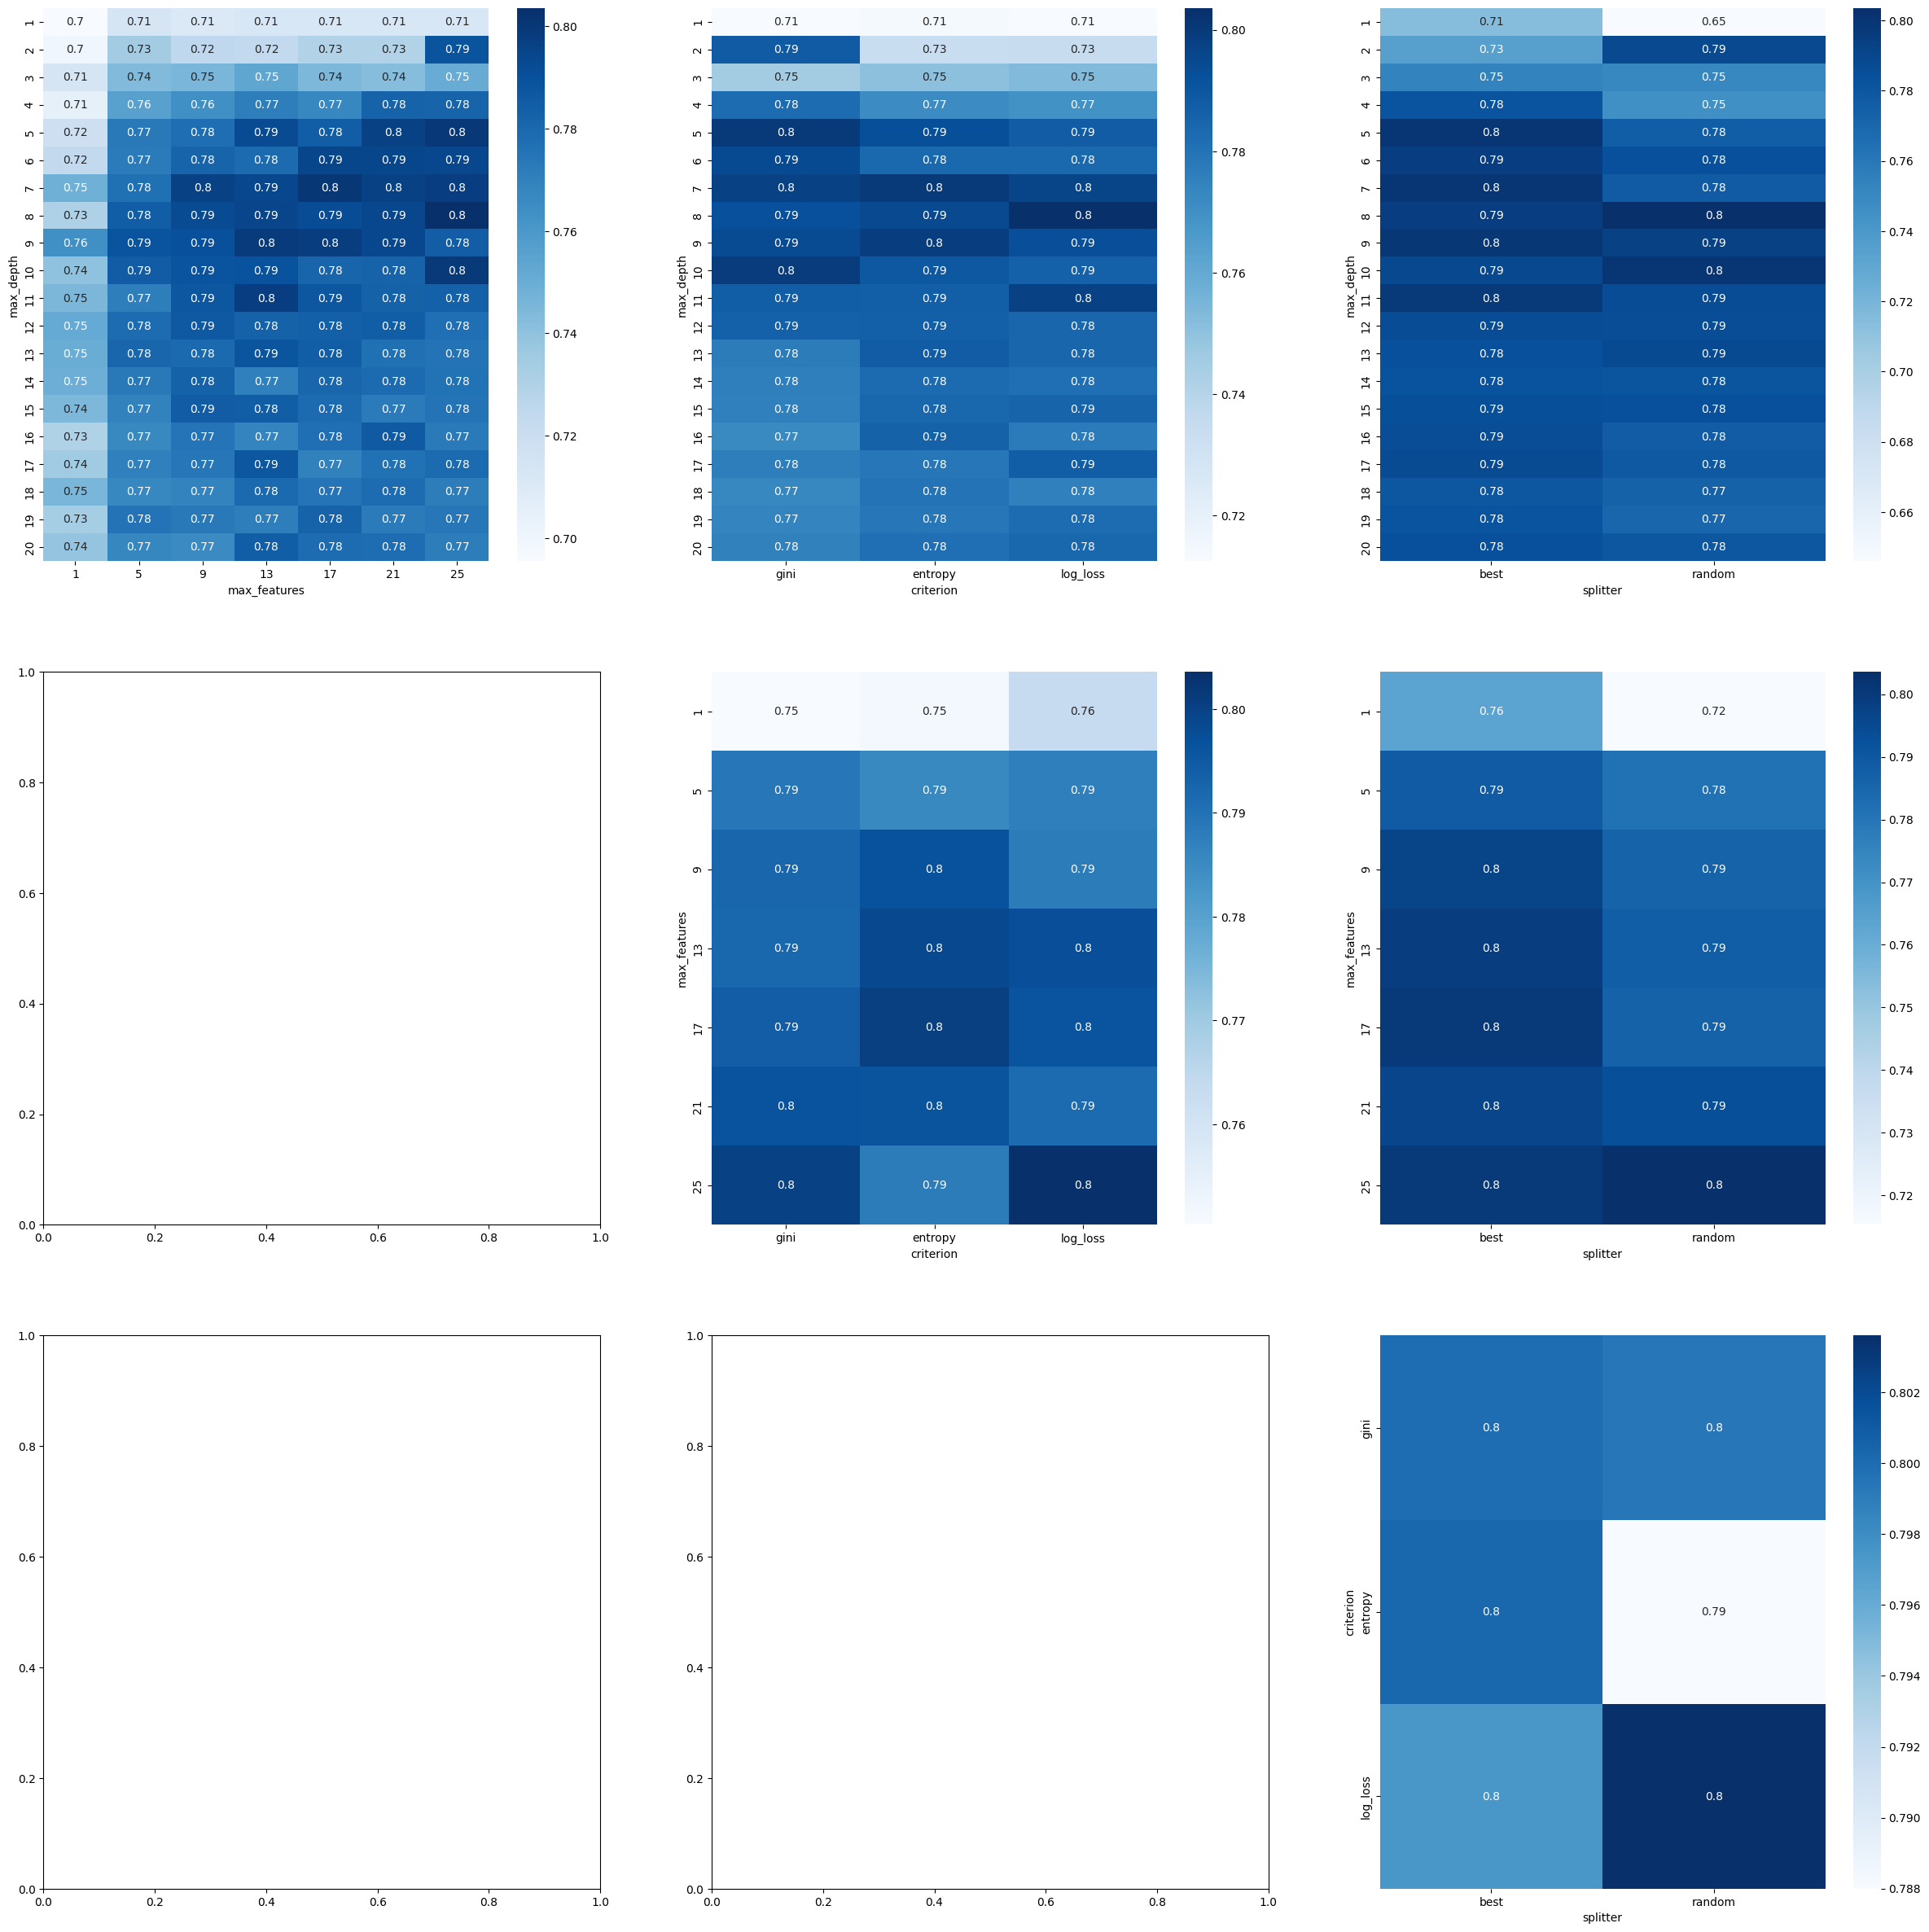

In [108]:
parameter_names_dt = list(parameter_grid_dt.keys())
plot_grid_search(
    grid_search_dt,
    "mean_test_accuracy",
    parameter_grid_dt,
    parameter_names_dt,
    "heatmaps_decision_tree.png",
)

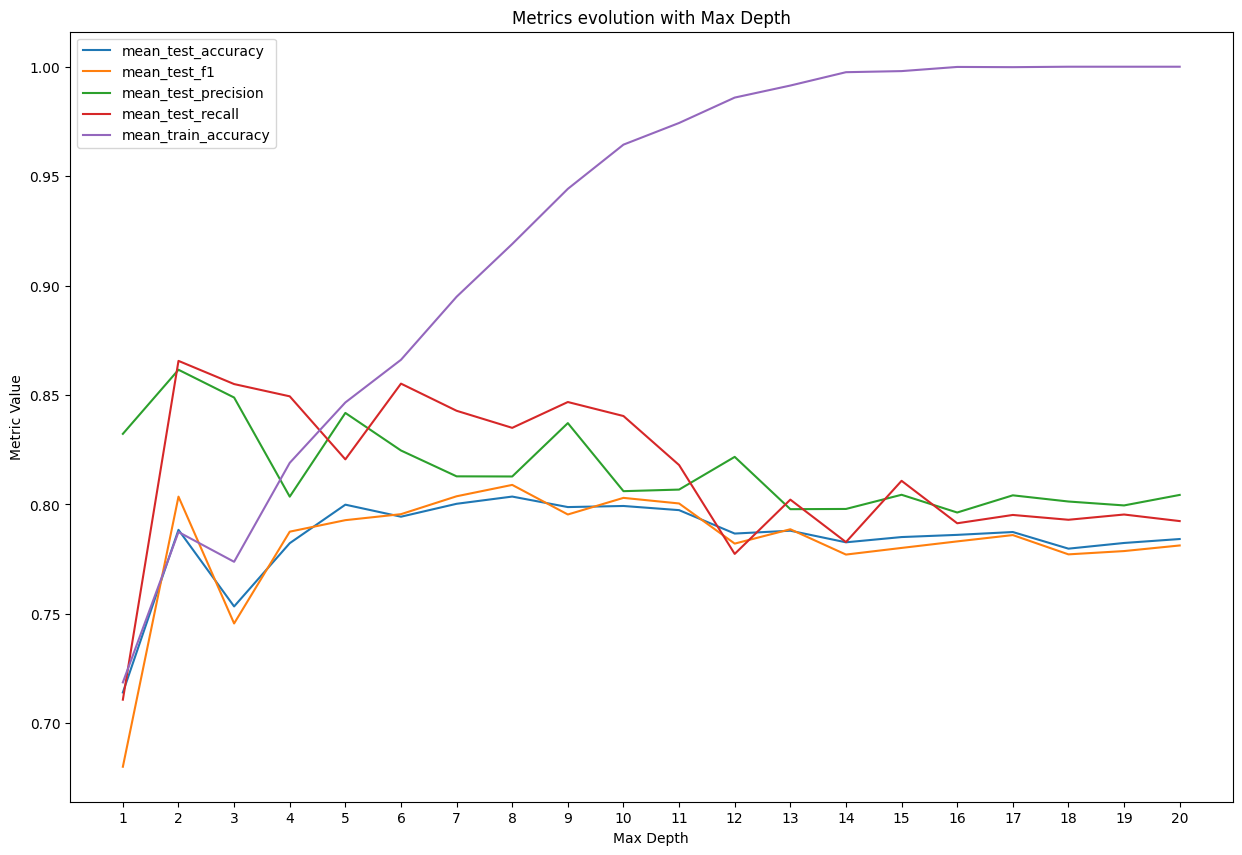

In [109]:
plot_measures(
    "max_depth",
    "Max Depth",
    parameter_grid_dt["max_depth"],
    grid_search_dt.cv_results_,
    [f"mean_test_{metric}" for metric in dt_metrics] + ["mean_train_accuracy"],
    "max_depth_decision_tree.png",
)

## K-NN: Nearest Neighbour

In [110]:
nearest_neighbour = KNeighborsClassifier()

max_leaf_size = 40

knn_metrics = ["accuracy", "f1", "precision", "recall"]
parameter_grid_knn = {
    "n_neighbors": [1, 3, 5, 10, 20, 30, 40, 50],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    # "leaf_size": [1, 5, 10, 25, 50, 100, 200, 500],
}

print(parameter_grid_knn)

grid_search_knn = test_classifier(
    nearest_neighbour, all_inputs_normalized, all_labels, parameter_grid_knn, return_metrics=knn_metrics, optimize_metric="f1", return_train_score=True
)

{'n_neighbors': [1, 3, 5, 10, 20, 30, 40, 50], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best score: 0.795045919673148
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'}


In [111]:
best_params["KNN"] = grid_search_knn.best_params_

Best score: 0.795045919673148
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'}


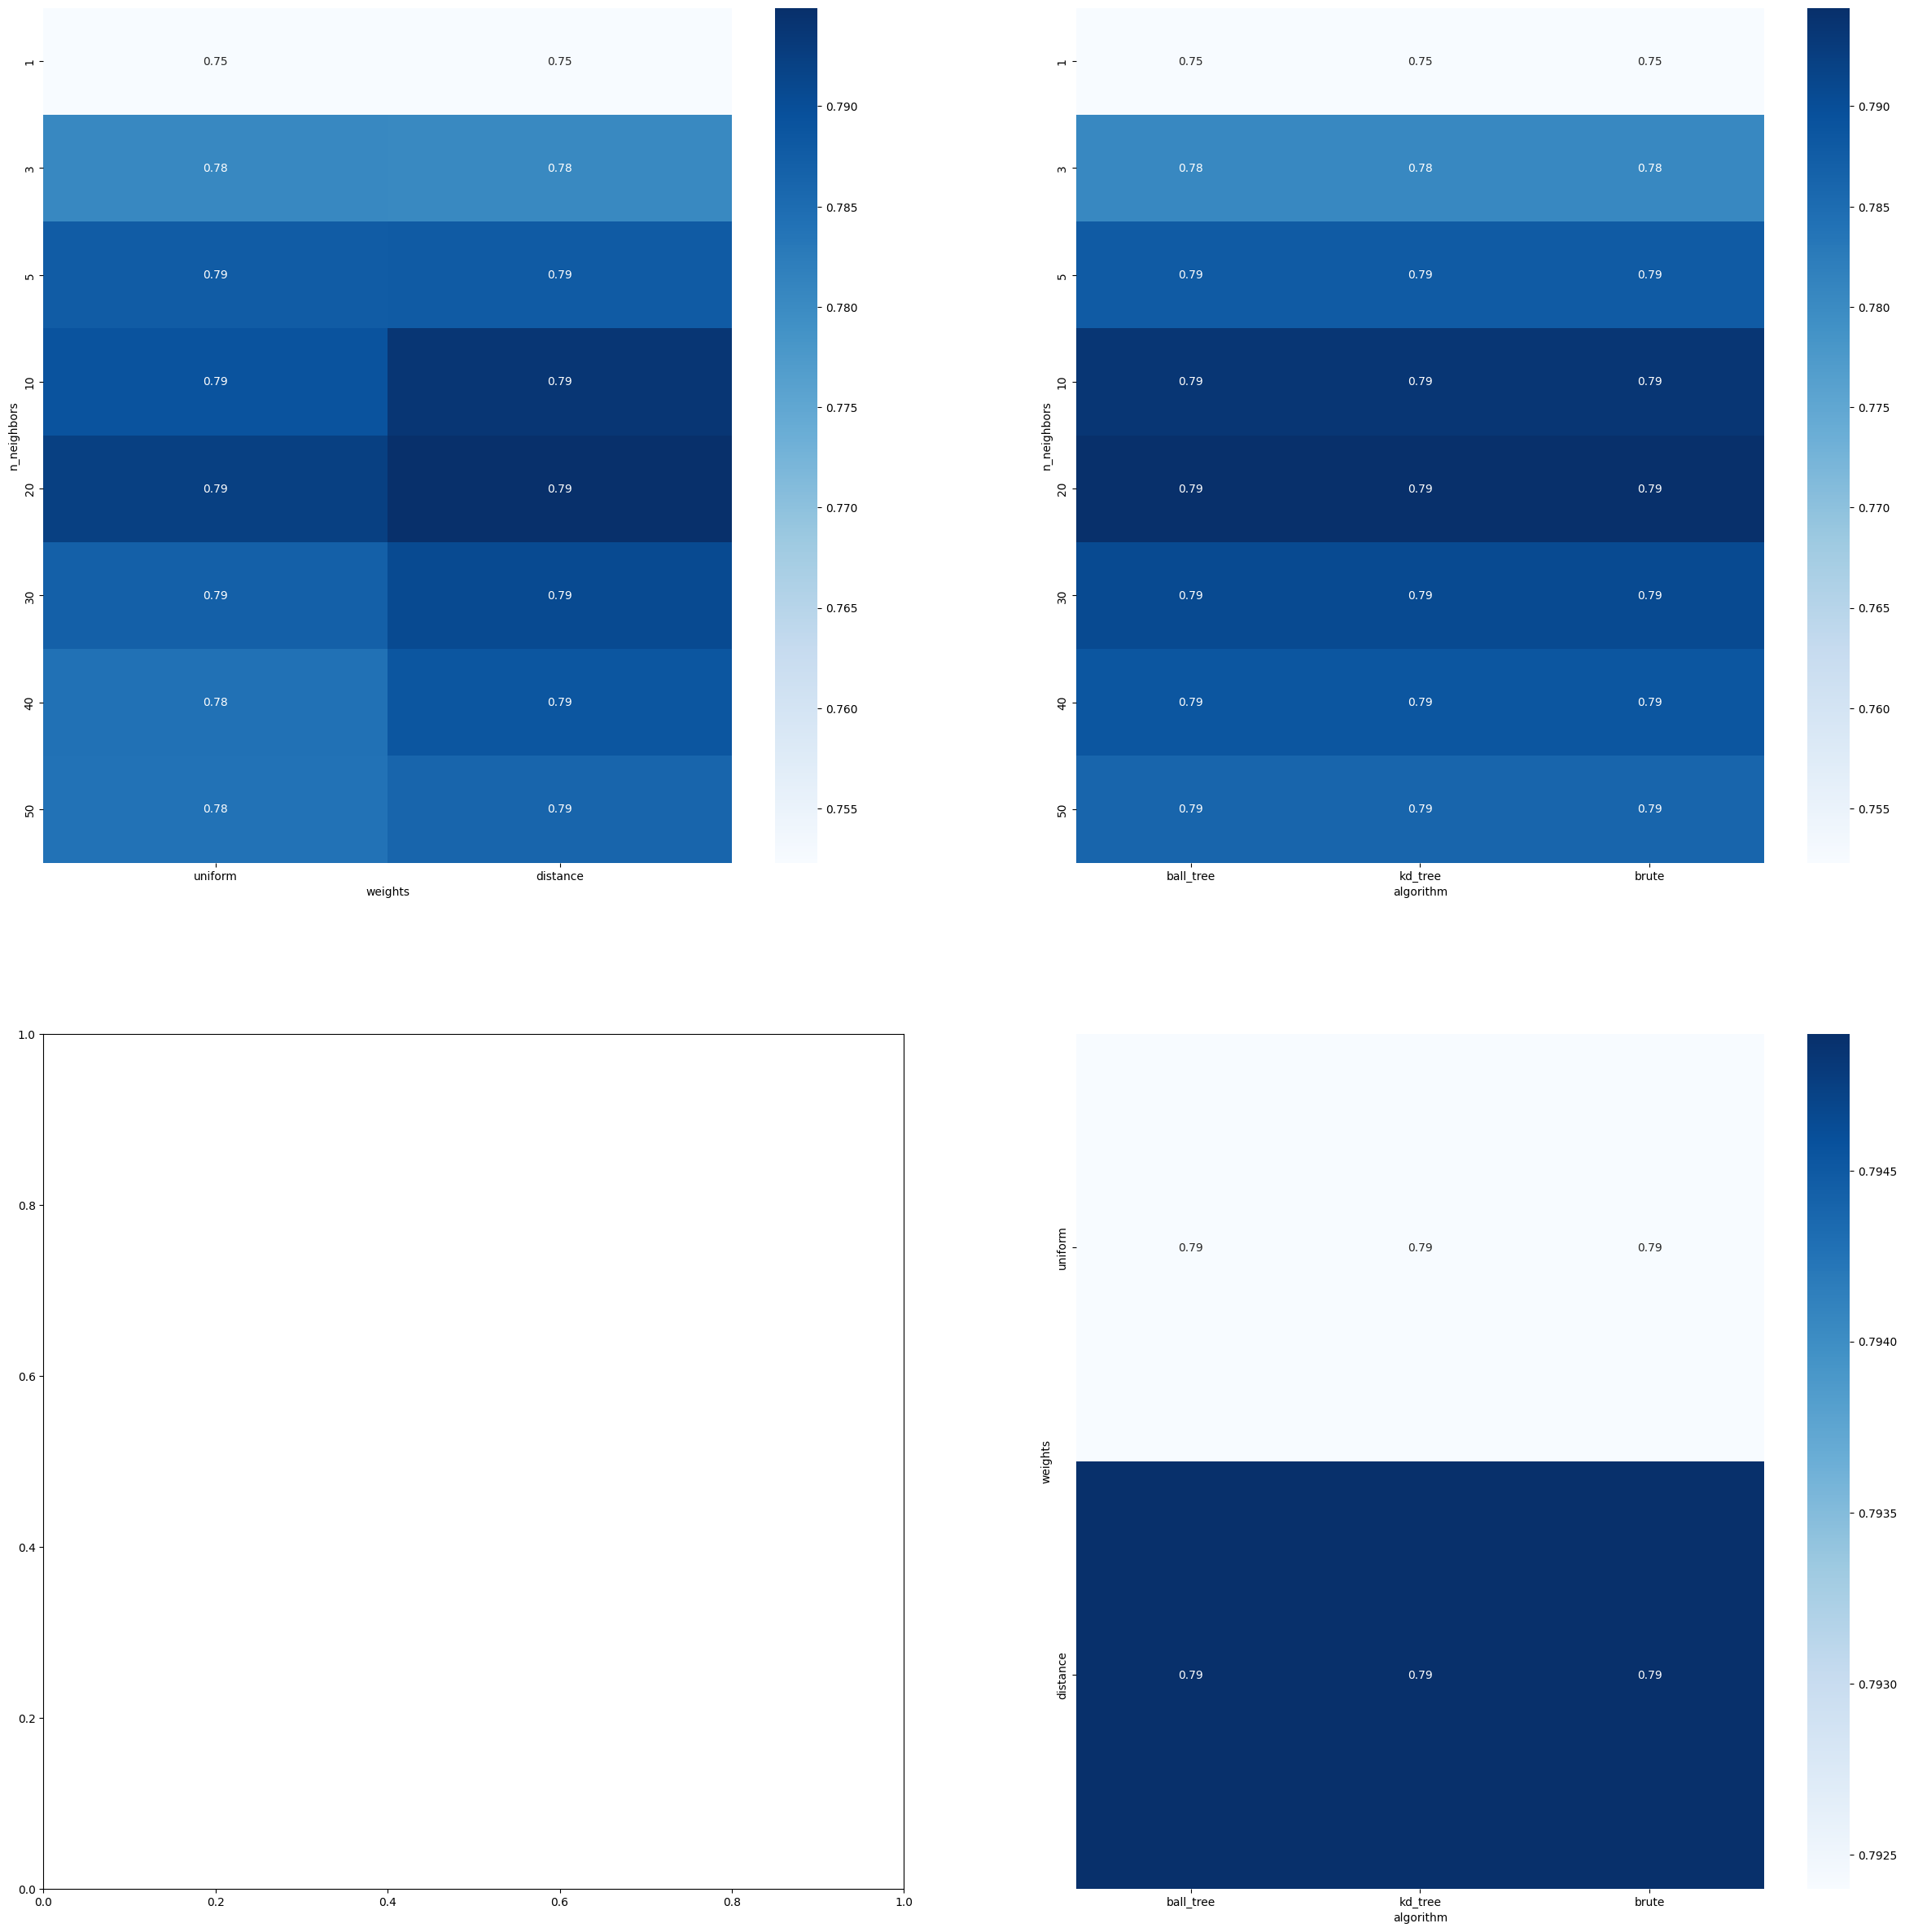

In [112]:
parameter_names_knn = list(parameter_grid_knn.keys())
plot_grid_search(
    grid_search_knn,
    "mean_test_accuracy",
    parameter_grid_knn,
    parameter_names_knn,
    "heatmaps_knn",
)

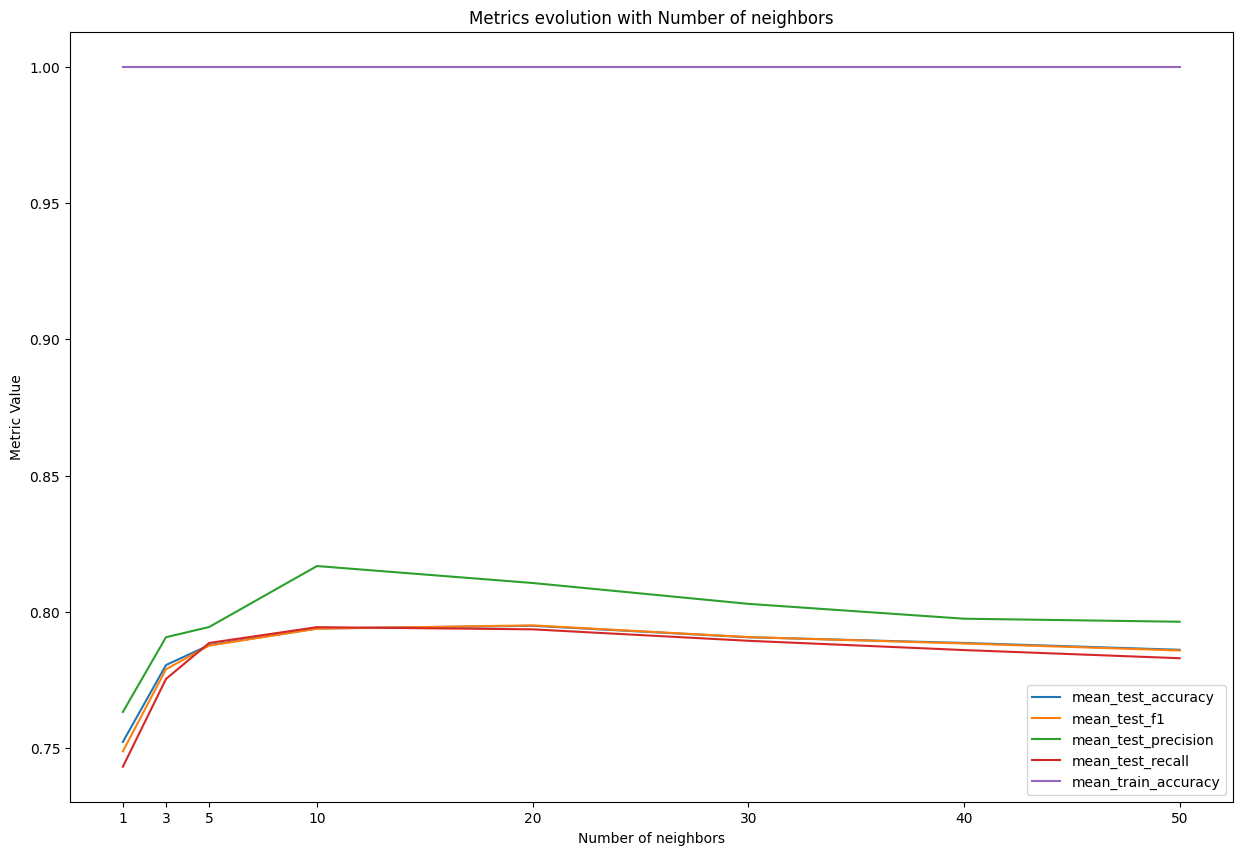

In [113]:
plot_measures(
    "n_neighbors",
    "Number of neighbors",
    parameter_grid_knn["n_neighbors"],
    grid_search_knn.cv_results_,
    [f"mean_test_{metric}" for metric in knn_metrics] + ["mean_train_accuracy"],
    "metrics_vs_neighbors.png",
)

## SVM: Support Vector Machine

In [114]:
C_list = [0.1, 0.5, 1, 3, 5]
gamma_list = ["scale", "auto"]
coef0_list = [-2, 0, 2]
shrinking_list = [True, False]
class_weight = ["balanced", None]

svm_metrics = ["f1", "accuracy", "precision", "recall"]

### SVM Linear

In [115]:
svm_linear = SVC(kernel="linear")

parameter_grid_linear = {
    "C": C_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_linear)

grid_search_linear = test_classifier(
    svm_linear,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_linear,
    return_metrics=svm_metrics,
    optimize_metric="f1"
)

{'C': [0.1, 0.5, 1, 3, 5], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best score: 0.8458969546823976
Best parameters: {'C': 3, 'class_weight': 'balanced', 'shrinking': False}


In [116]:
linear_clf_report = get_best_estimator_report(grid_search_linear)
linear_clf_report
print(grid_search_linear.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_shrinking', 'params', 'split0_test_f1', 'split1_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_accuracy', 'split1_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall'])


Best score: 0.8458969546823976
Best parameters: {'C': 3, 'class_weight': 'balanced', 'shrinking': False}


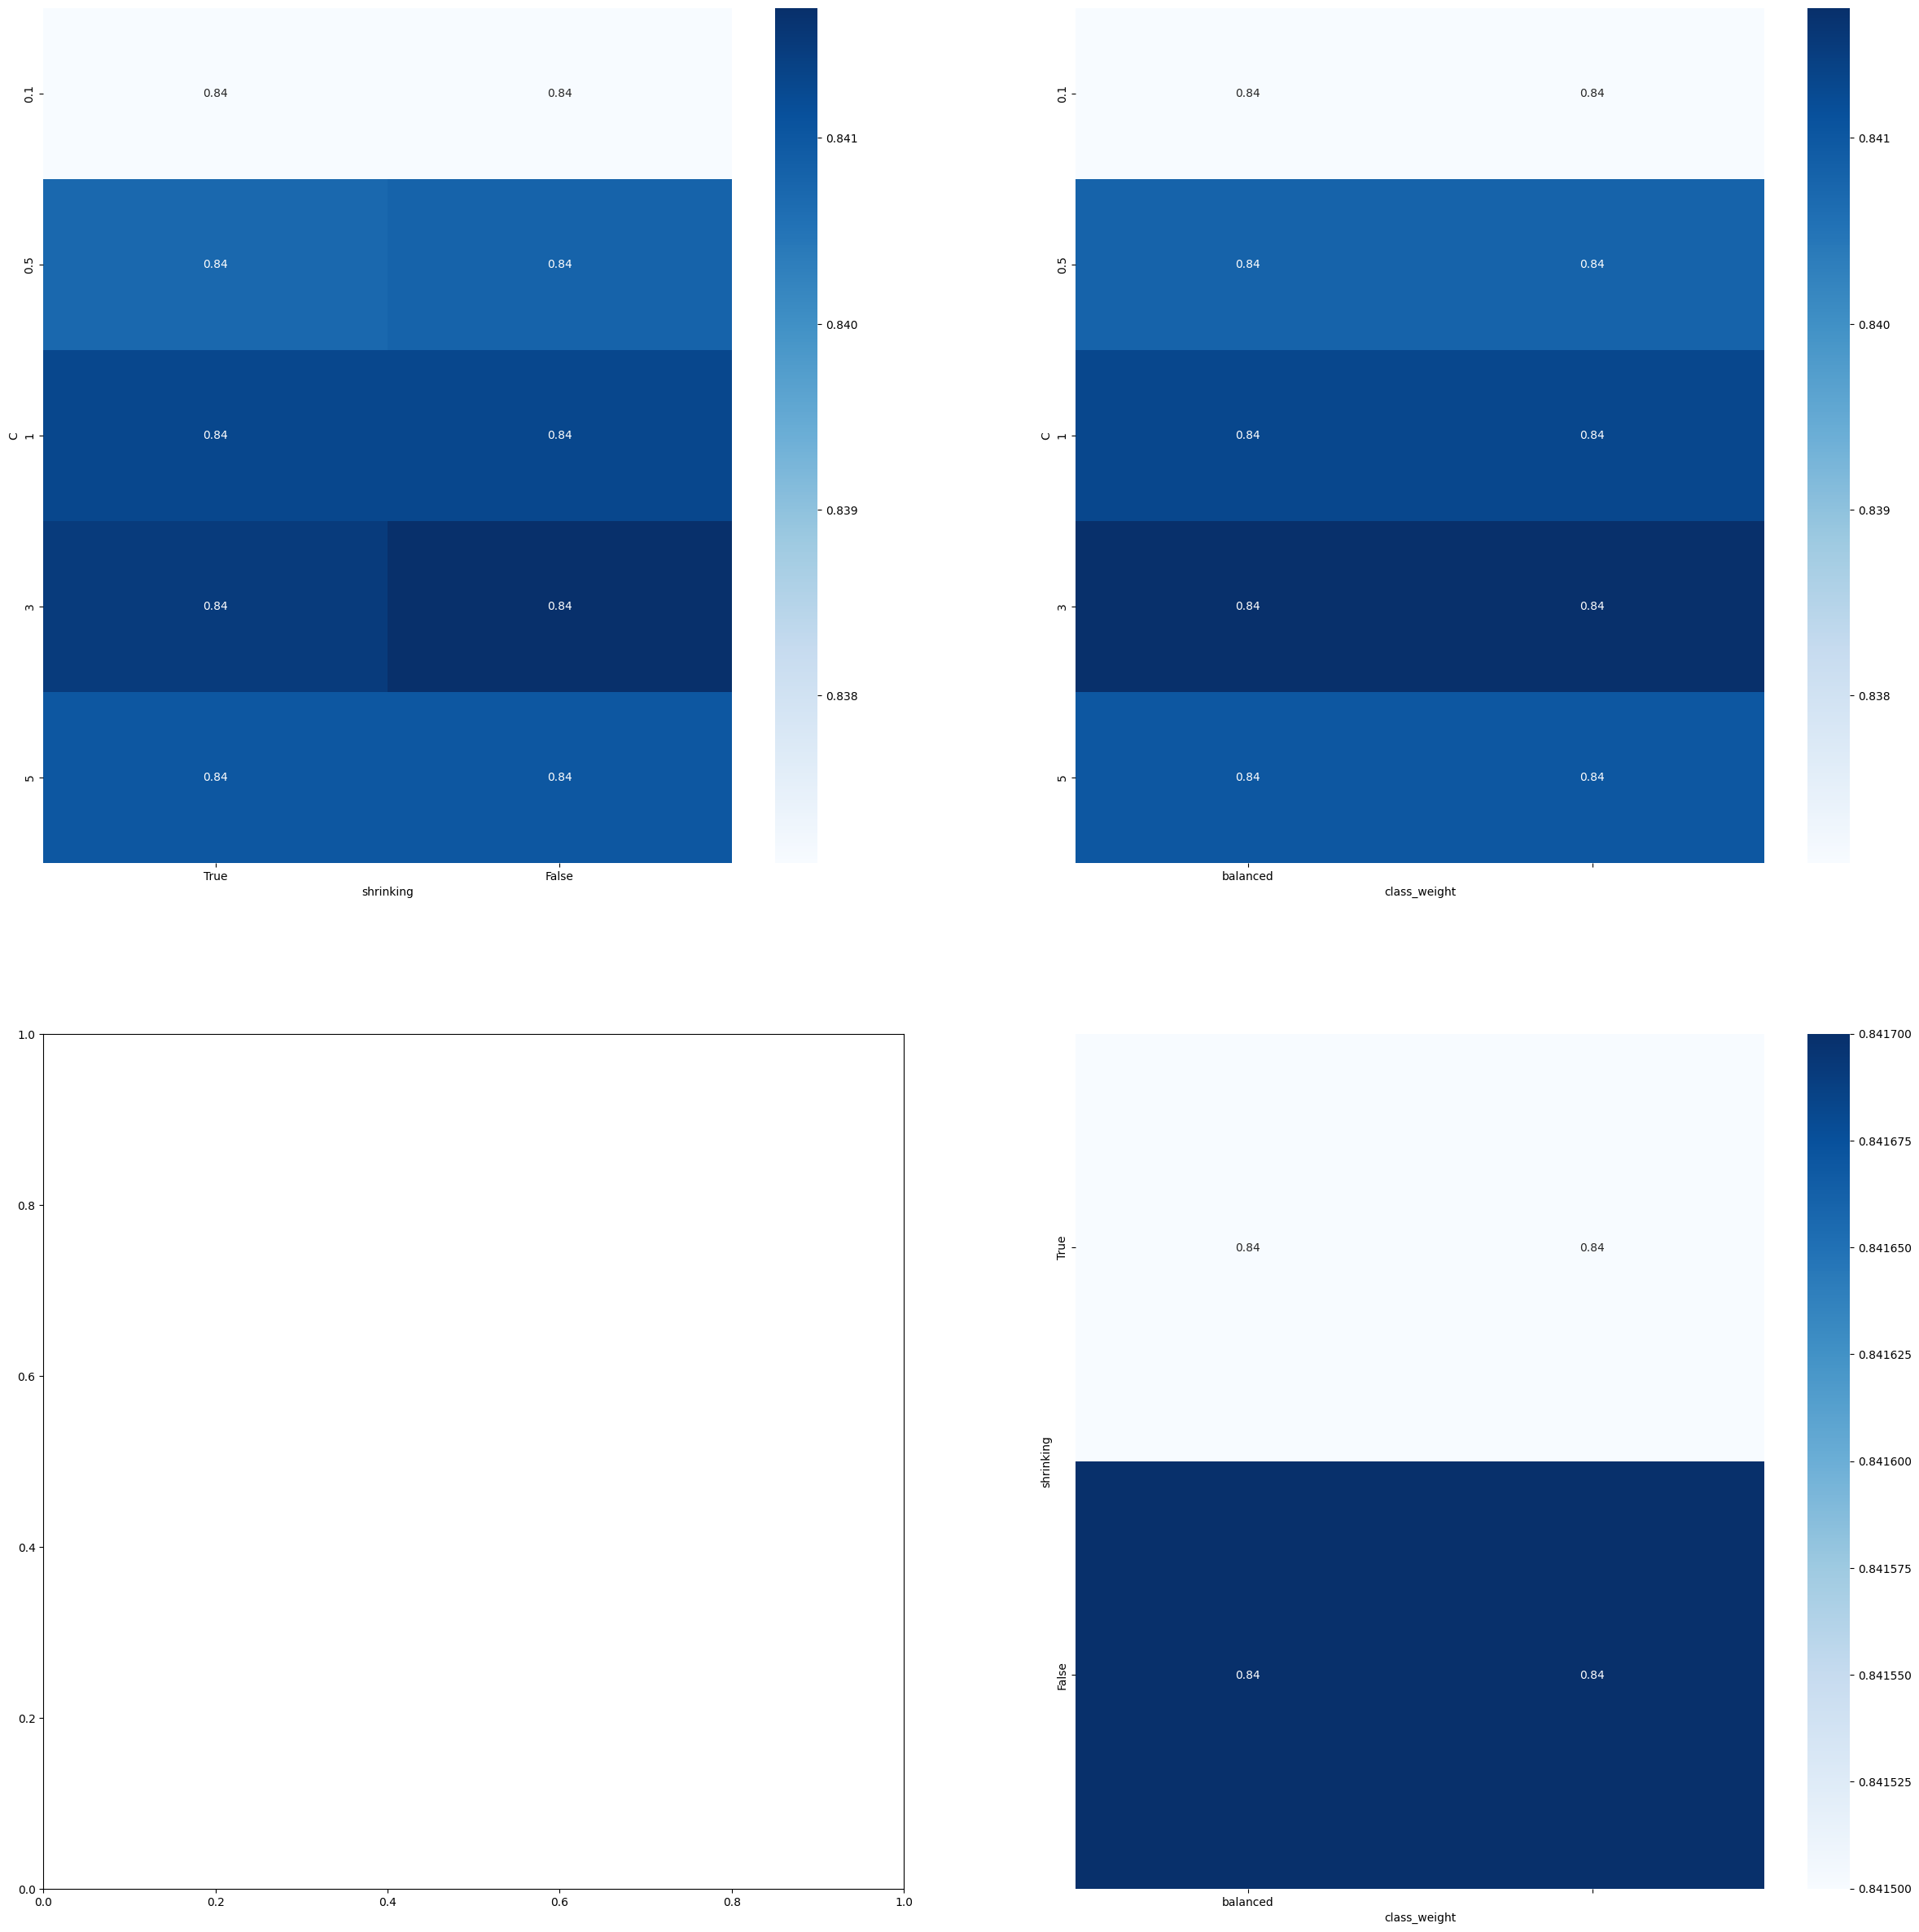

In [117]:
parameter_names_linear = list(parameter_grid_linear.keys())
plot_grid_search(
    grid_search_linear,
    "mean_test_accuracy",
    parameter_grid_linear,
    parameter_names_linear,
    "heatmaps_svm_linear",
)

### SVM Polynomial

In [118]:
svm_poly = SVC(kernel="poly")

parameter_grid_poly = {
    "C": C_list,
    "degree": list(range(1, 6, 2)),
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_poly)

grid_search_poly = test_classifier(
    svm_poly,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_poly,
    return_metrics=svm_metrics,
    optimize_metric="f1"
)

{'C': [0.1, 0.5, 1, 3, 5], 'degree': [1, 3, 5], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 360 candidates, totalling 720 fits
Best score: 0.8564873847802488
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'coef0': 2, 'degree': 3, 'gamma': 'auto', 'shrinking': True}


In [119]:
poly_clf_report = get_best_estimator_report(grid_search_poly)
poly_clf_report

{'recall': 0.888,
 'f1': 0.8564873847802488,
 'precision': 0.8282055932539062,
 'accuracy': 0.8508}

Best score: 0.8564873847802488
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'coef0': 2, 'degree': 3, 'gamma': 'auto', 'shrinking': True}


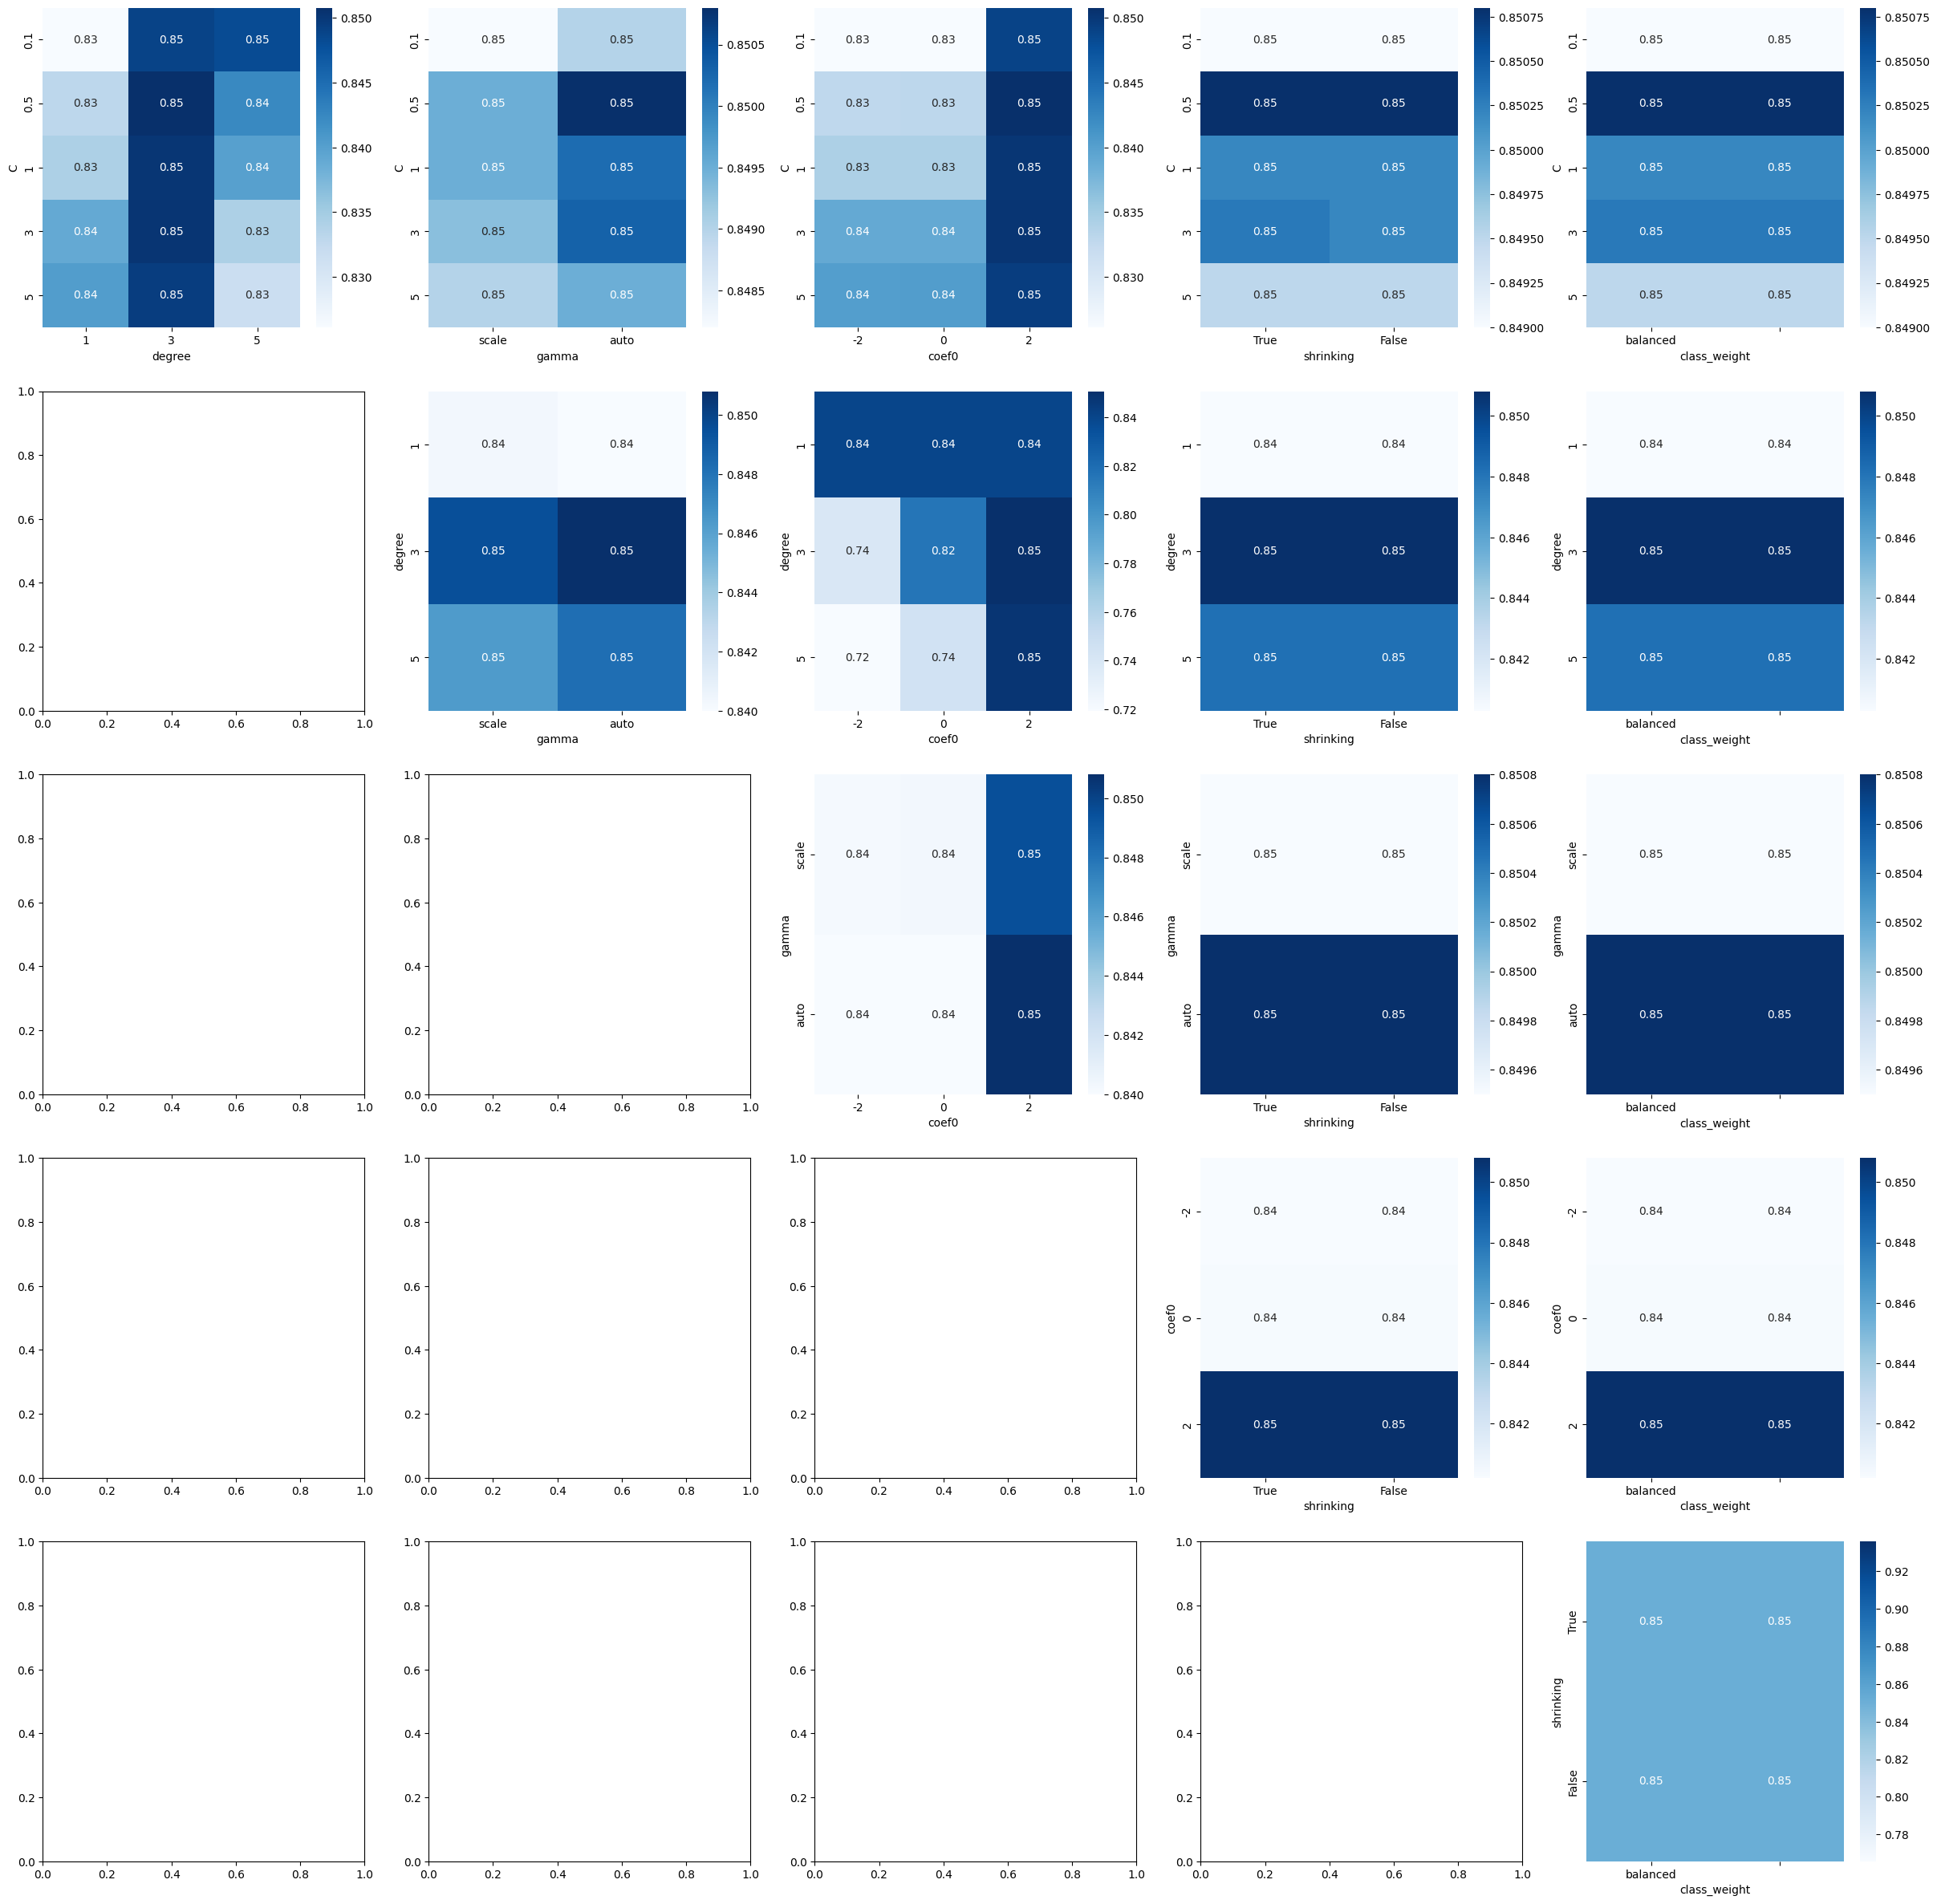

In [120]:
parameter_names_poly = list(parameter_grid_poly.keys())
plot_grid_search(
    grid_search_poly, "mean_test_accuracy", parameter_grid_poly, parameter_names_poly, "heatmaps_svm_poly"
)

### SVM Radial Basis Function

In [121]:
svm_rbf = SVC(kernel="rbf")

parameter_grid_rbf = {
    "C": C_list,
    "gamma": gamma_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_rbf)

grid_search_rbf = test_classifier(
    svm_rbf,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_rbf,
    return_metrics=svm_metrics,
    optimize_metric="f1",
)

{'C': [0.1, 0.5, 1, 3, 5], 'gamma': ['scale', 'auto'], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 40 candidates, totalling 80 fits
Best score: 0.857287170837739
Best parameters: {'C': 3, 'class_weight': 'balanced', 'gamma': 'auto', 'shrinking': True}


In [122]:
rbf_clf_report = get_best_estimator_report(grid_search_rbf)
rbf_clf_report

{'recall': 0.8918,
 'f1': 0.857287170837739,
 'precision': 0.8260040396983375,
 'accuracy': 0.8512}

Best score: 0.857287170837739
Best parameters: {'C': 3, 'class_weight': 'balanced', 'gamma': 'auto', 'shrinking': True}


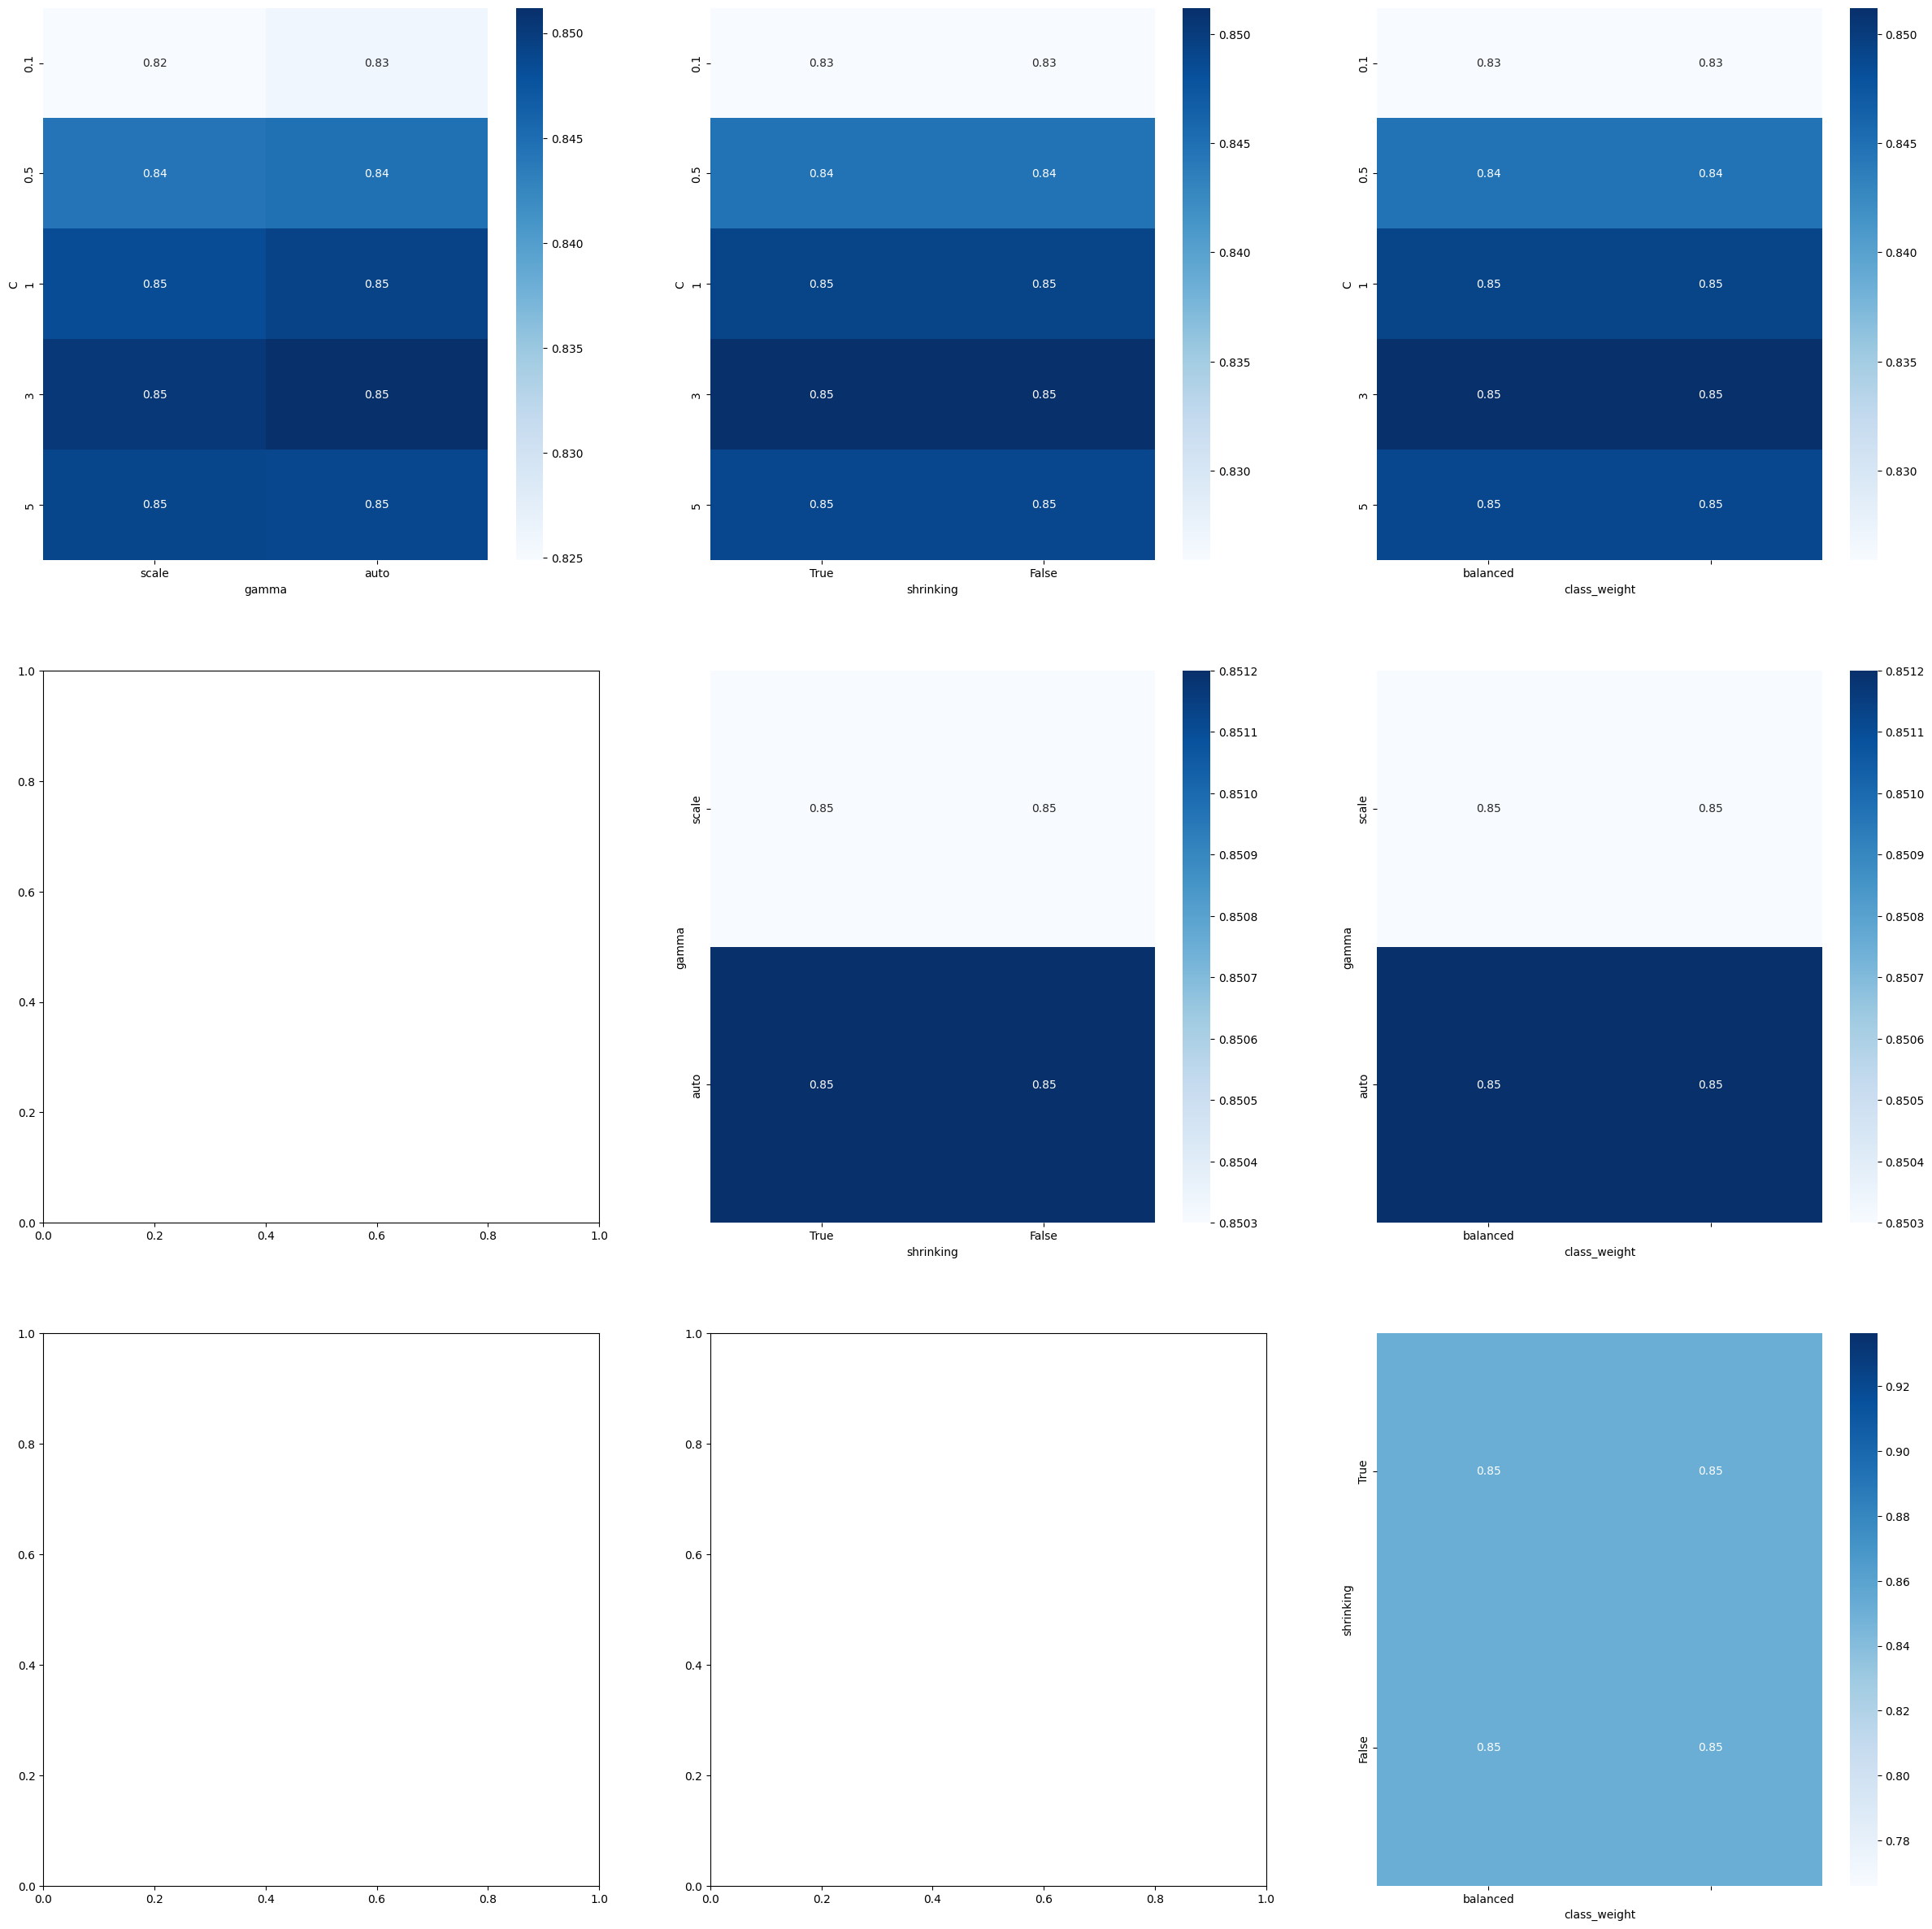

In [123]:
parameter_names_rbf = list(parameter_grid_rbf.keys())
plot_grid_search(
    grid_search_rbf, "mean_test_accuracy", parameter_grid_rbf, parameter_names_rbf, "heatmaps_svm_rbf"
)

### SVM Sigmoid

In [124]:
svm_sigmoid = SVC(kernel="sigmoid")

parameter_grid_sigmoid = {
    "C": C_list,
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_sigmoid)

grid_search_sigmoid = test_classifier(
    svm_sigmoid,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_sigmoid,
    return_metrics=svm_metrics,
    optimize_metric="f1"
)

{'C': [0.1, 0.5, 1, 3, 5], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 120 candidates, totalling 240 fits
Best score: 0.7728818405893858
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'auto', 'shrinking': True}


In [125]:
sigmoid_clf_report = get_best_estimator_report(grid_search_sigmoid)
sigmoid_clf_report

{'recall': 0.787,
 'f1': 0.7728818405893858,
 'precision': 0.7598981890324914,
 'accuracy': 0.7687999999999999}

Best score: 0.7728818405893858
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'auto', 'shrinking': True}


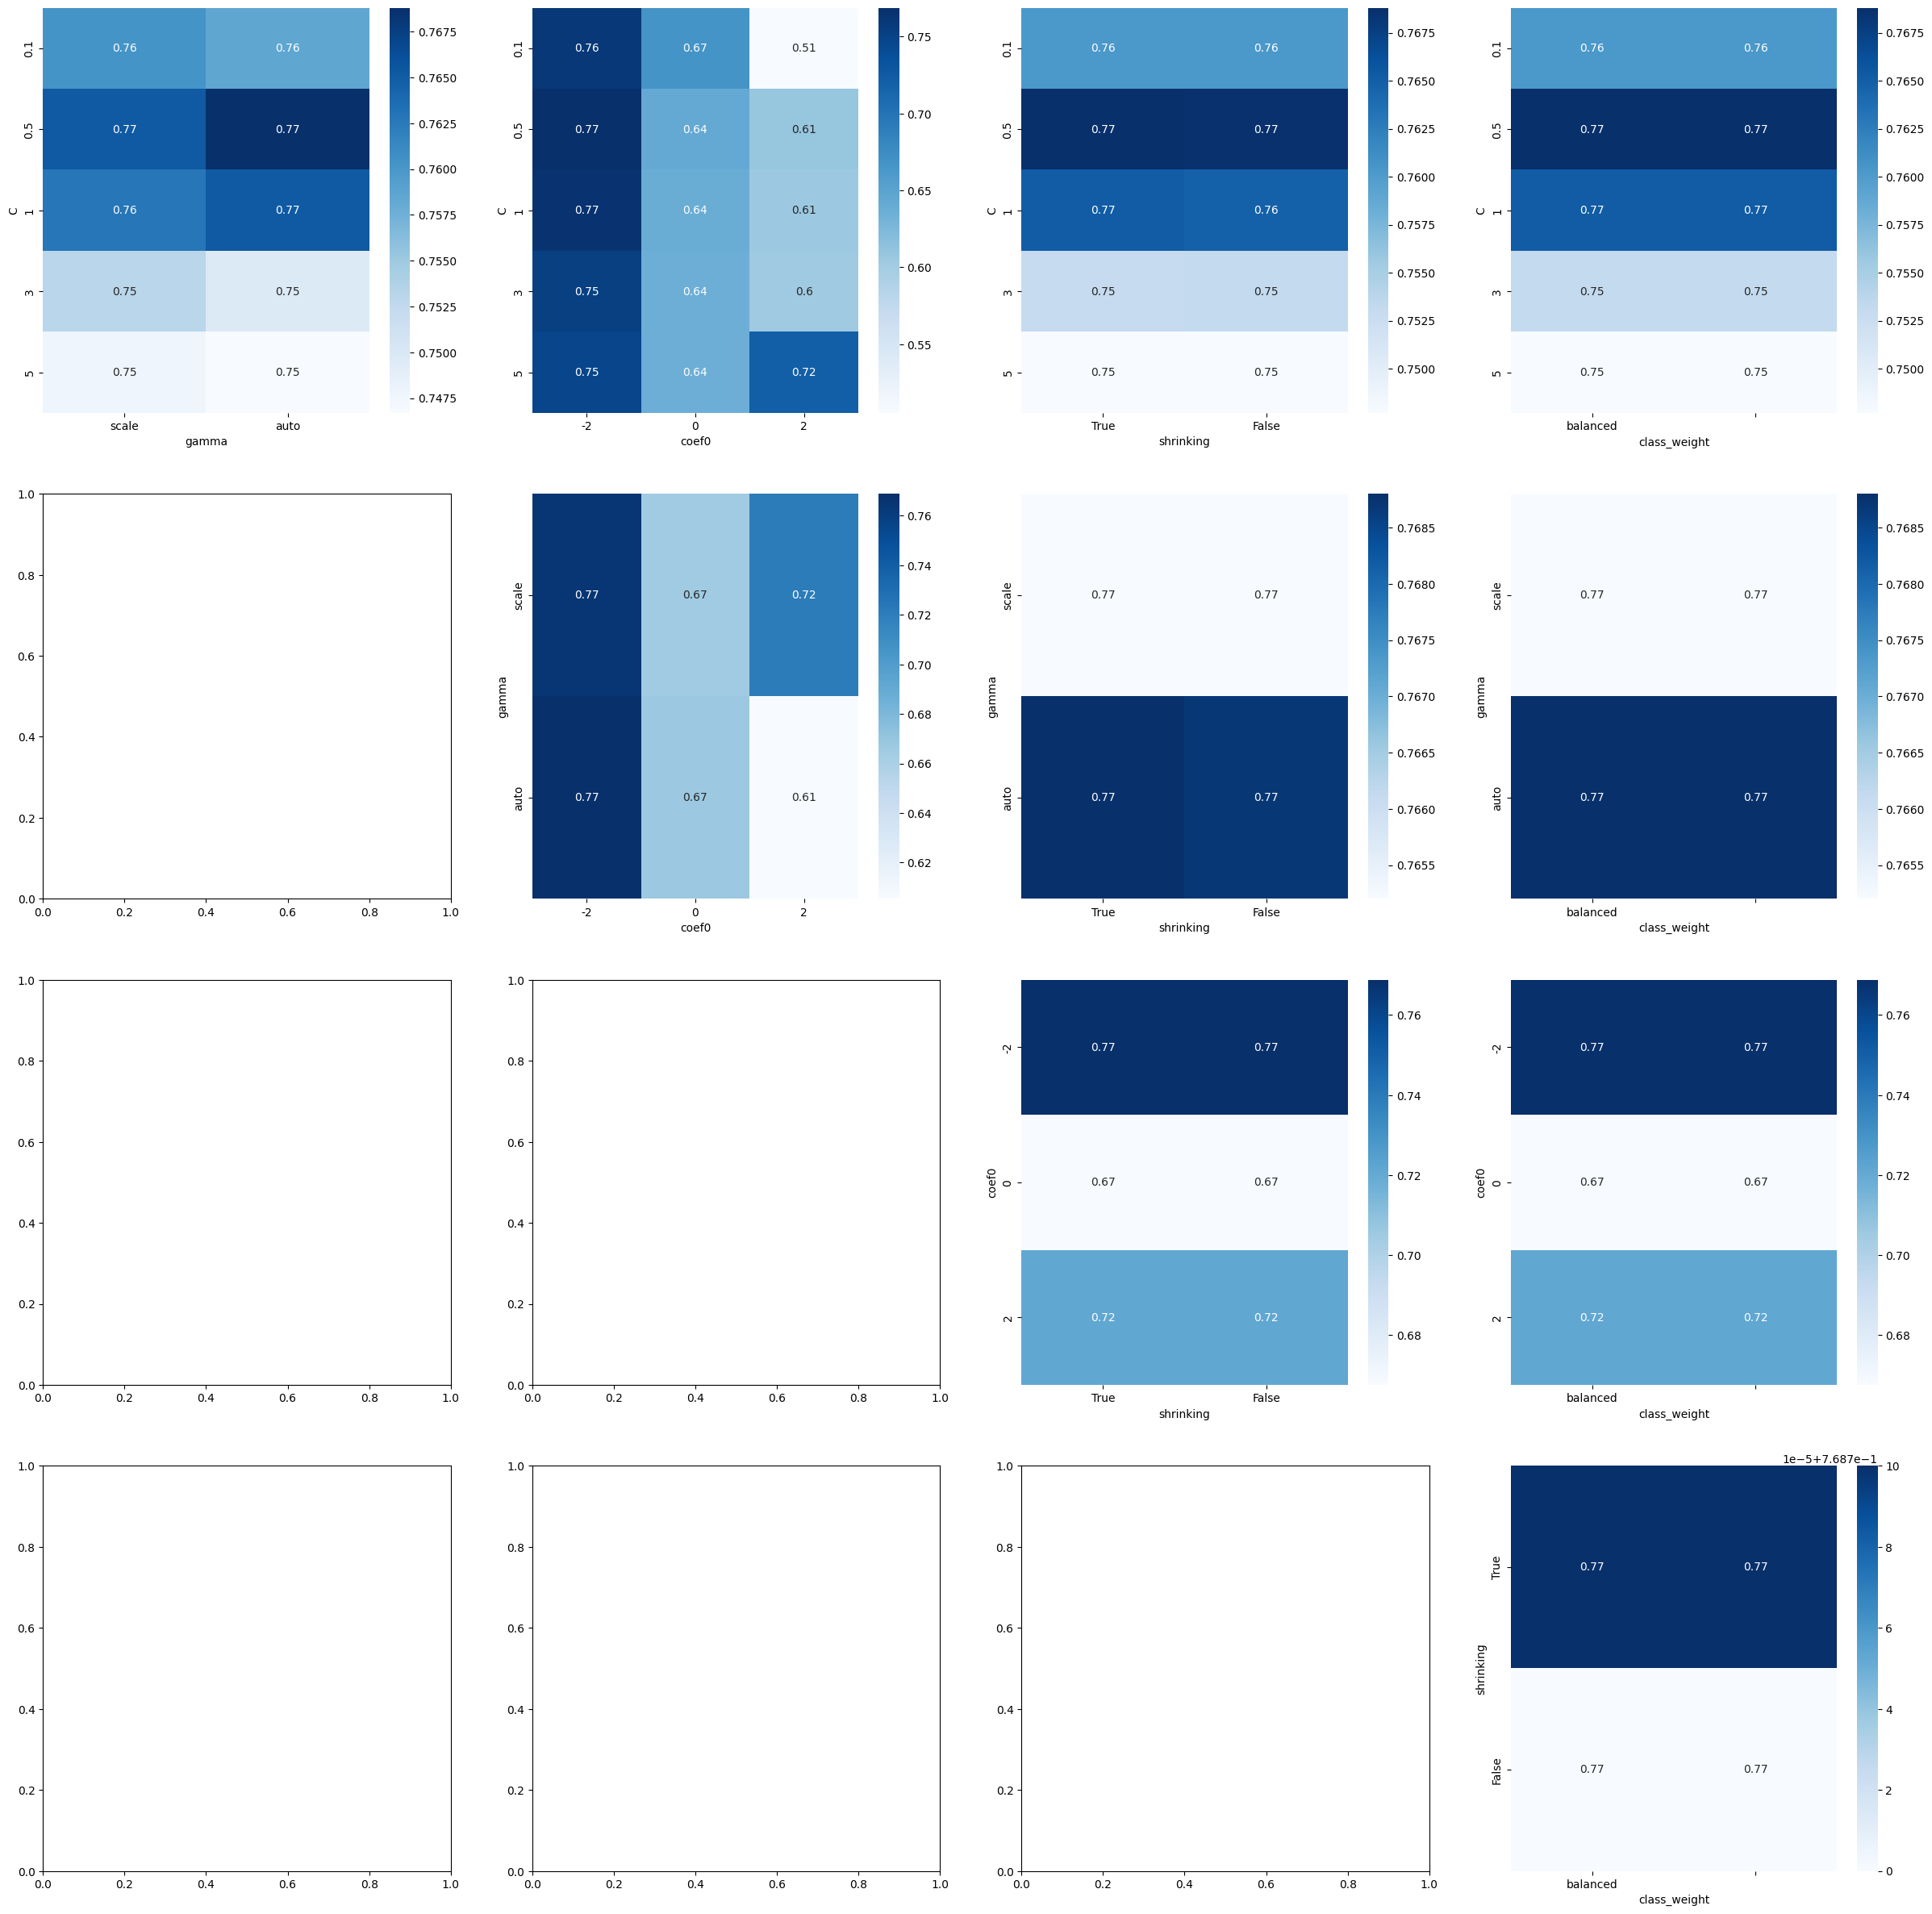

In [126]:
parameter_names_sigmoid = list(parameter_grid_sigmoid.keys())
plot_grid_search(
    grid_search_sigmoid,
    "mean_test_accuracy",
    parameter_grid_sigmoid,
    parameter_names_sigmoid,
    "heatmaps_svm_sigmoid",
)

In [127]:
all_svms_scores_and_params = [(grid_search_linear.best_score_, grid_search_linear.best_params_), (grid_search_poly.best_score_, grid_search_poly.best_params_), (grid_search_rbf.best_score_, grid_search_rbf.best_params_), (grid_search_sigmoid.best_score_, grid_search_sigmoid.best_params_)]

best_svm_score, best_svm_params = max(all_svms_scores_and_params, key=lambda x: x[0])

best_params["SVM"] = best_svm_params

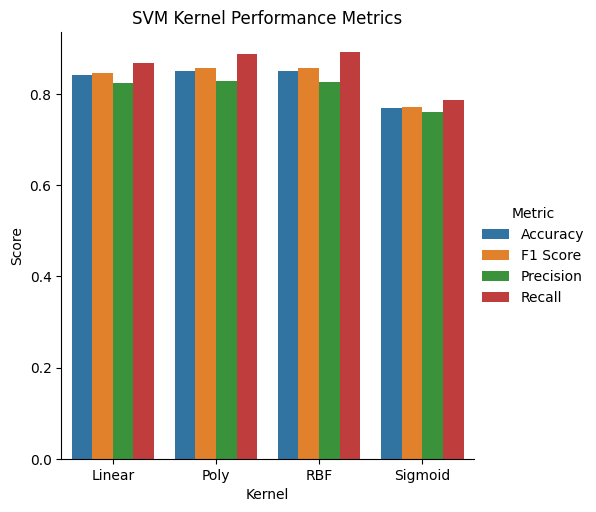

In [128]:
def plot_svms(linear_report, poly_report, rbf_report, sigmoid_report, filename):
    reports = [linear_report, poly_report, rbf_report, sigmoid_report]
    kernel_names = ["Linear", "Poly", "RBF", "Sigmoid"]

    data = []
    for kernel, report in zip(kernel_names, reports):
        data.append({
            "Kernel": kernel,
            "Metric": "Accuracy",
            "Score": report["accuracy"]
        })
        data.append({
            "Kernel": kernel,
            "Metric": "F1 Score",
            "Score": report["f1"]
        })
        data.append({
            "Kernel": kernel,
            "Metric": "Precision",
            "Score": report["precision"]
        })
        data.append({
            "Kernel": kernel,
            "Metric": "Recall",
            "Score": report["recall"]
        })

    data = pd.DataFrame(data)

    sb.catplot(x="Kernel", y="Score", hue="Metric", data=data, kind="bar", dodge=True, errorbar=None)
    plt.title('SVM Kernel Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Kernel')
    plt.savefig(get_images_file_path(filename), bbox_inches="tight")

plot_svms(linear_clf_report, poly_clf_report, rbf_clf_report, sigmoid_clf_report, "svms_metrics.png")

## Redes Neuronais

In [129]:
neural_networks = MLPClassifier()

activations = ["identity", "logistic", "tanh", "relu"]
solvers = ["lbfgs", "sgd", "adam"]
parameter_grid_neural_networks = {
    "activation": activations,
    "solver": solvers,
    "hidden_layer_sizes": [(100,), (50, 50, 50), (10, 10, 10, 10, 10)],
    "alpha": [0.0001, 0.05, 1],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [10, 50, 100, 200, 400],
}

print(parameter_grid_neural_networks)
nn_metrics = ["accuracy", "f1", "precision", "recall"]

grid_search_neural_networks = test_classifier(
    neural_networks,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_neural_networks,
    return_metrics=nn_metrics,
    optimize_metric="f1",
    return_train_score=True
)

{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(100,), (50, 50, 50), (10, 10, 10, 10, 10)], 'alpha': [0.0001, 0.05, 1], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': [10, 50, 100, 200, 400]}
Fitting 2 folds for each of 1620 candidates, totalling 3240 fits
Best score: 0.8612502696965053
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'adam'}


C:\Users\Clara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [130]:
best_params["Neural Network"] = grid_search_neural_networks.best_params_

Best score: 0.8612502696965053
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'adam'}


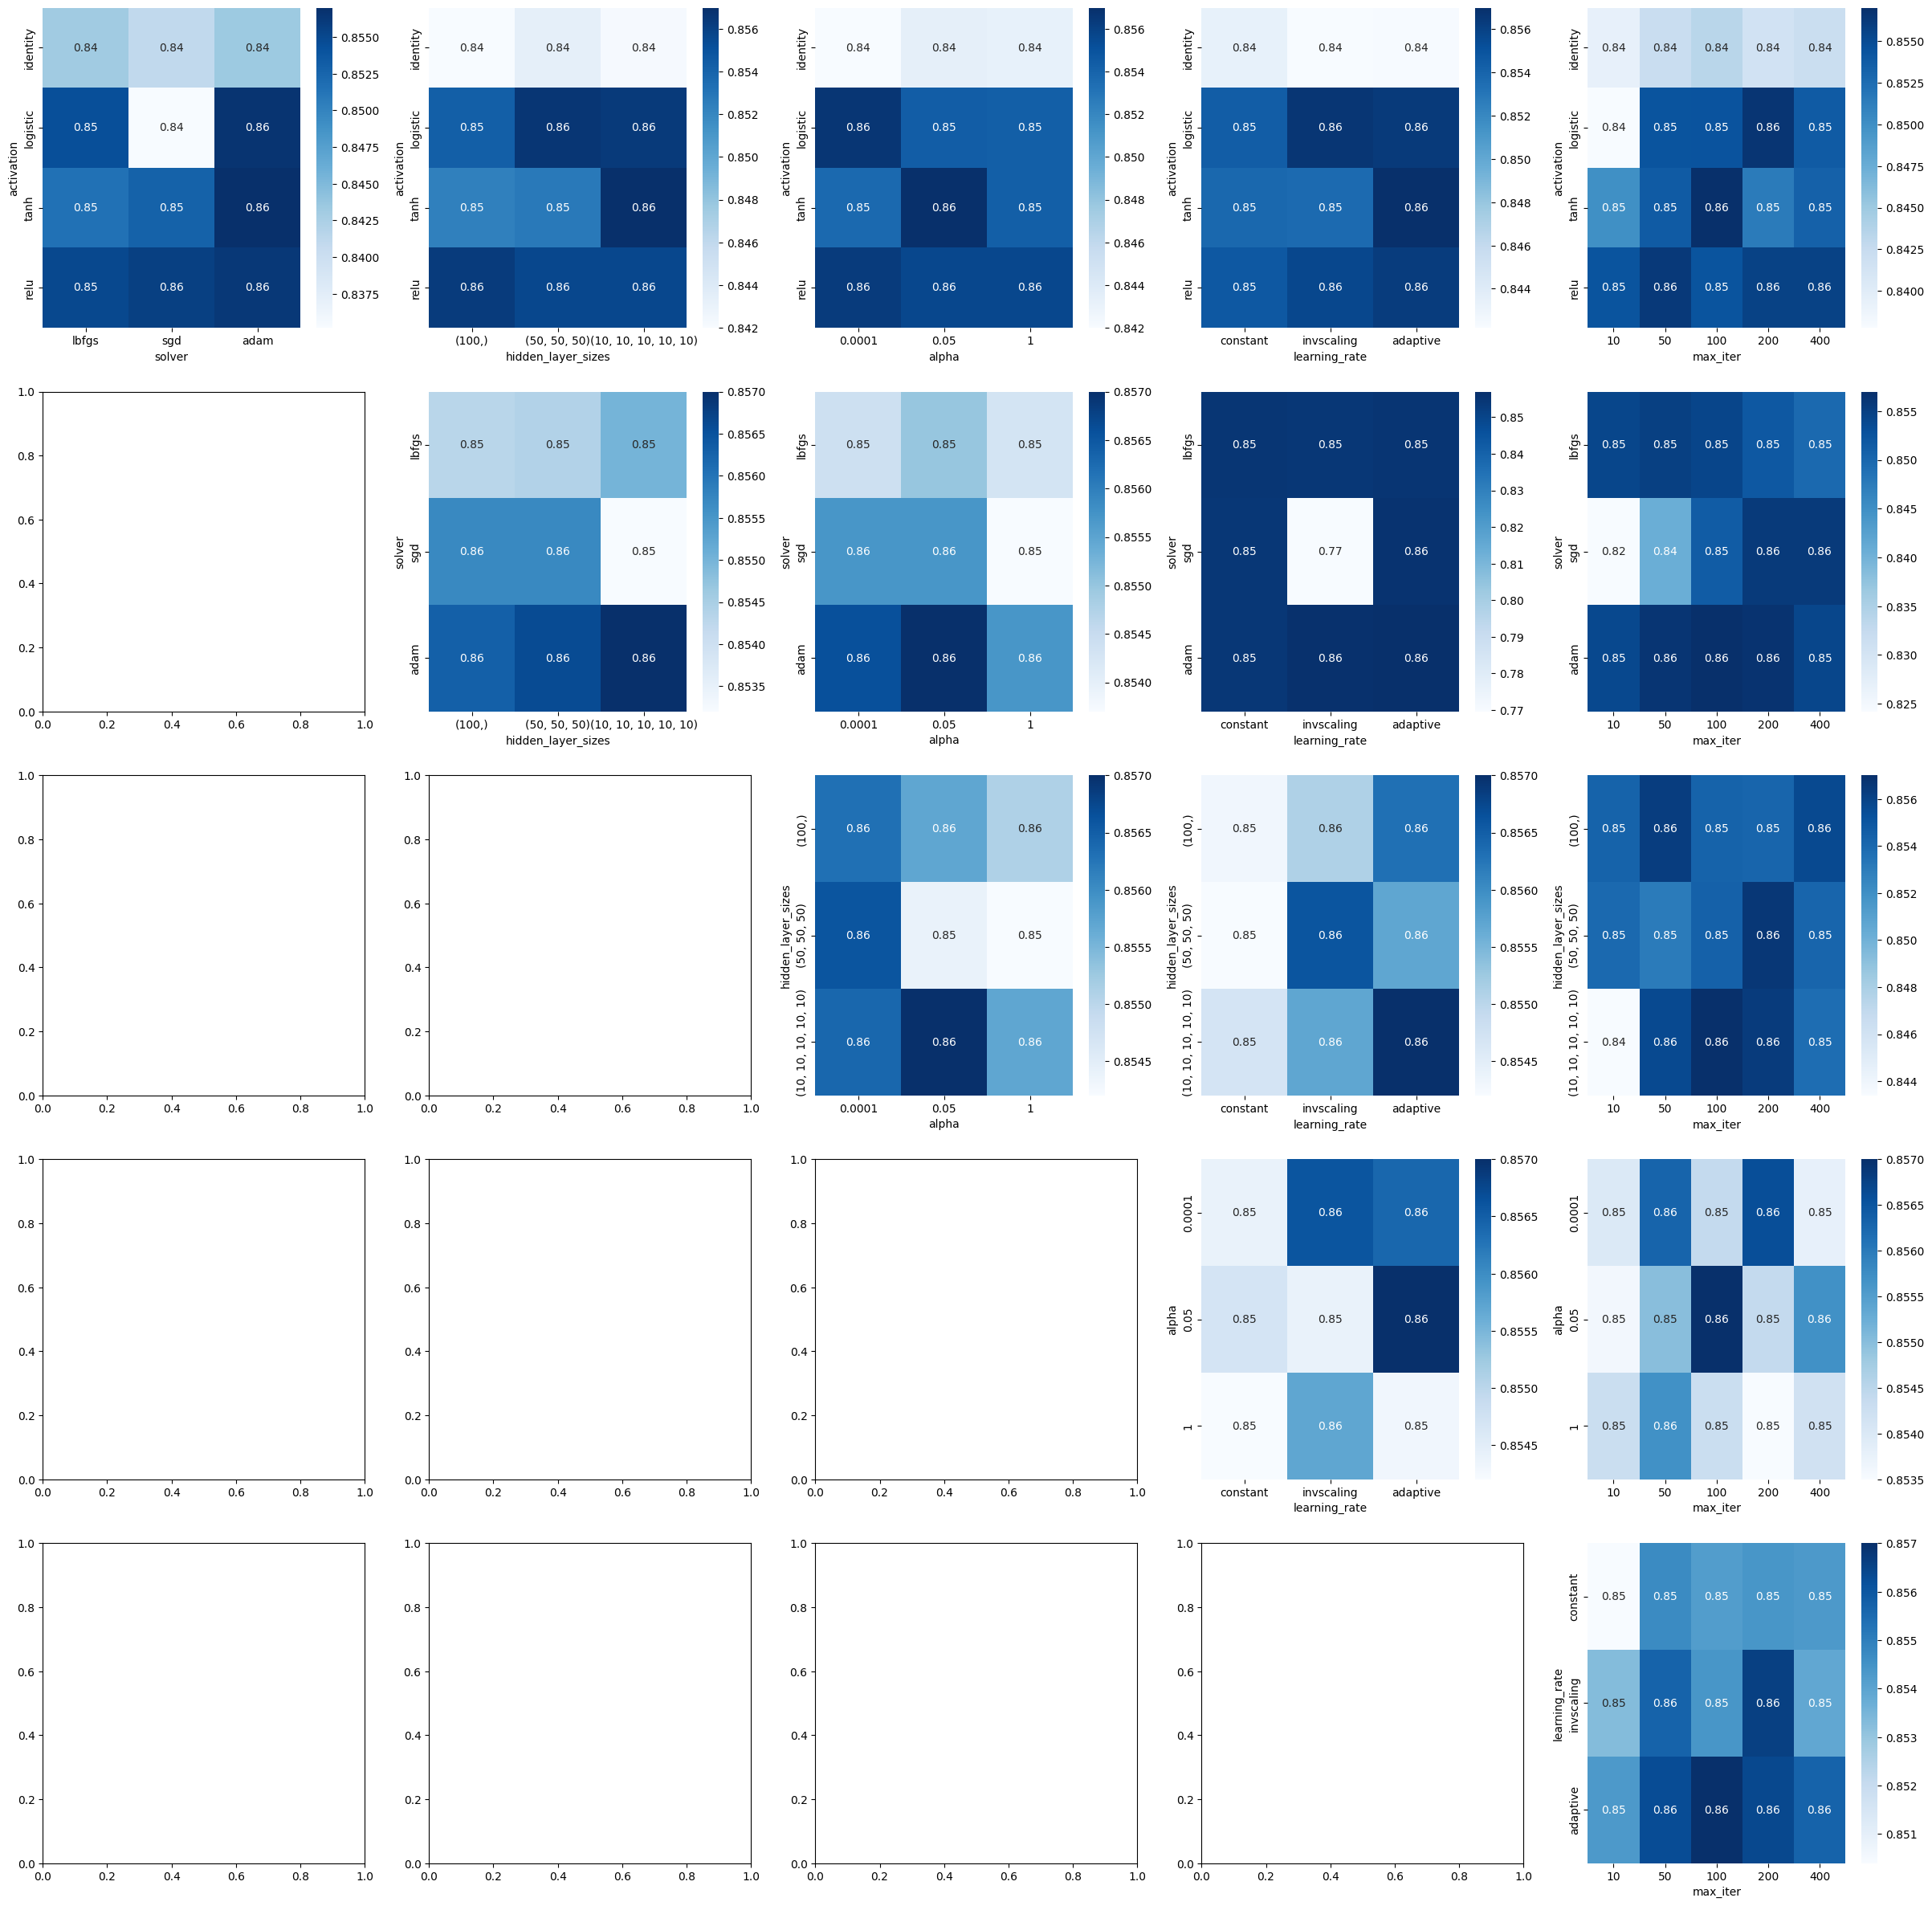

In [131]:
parameter_names_neural_networks = list(parameter_grid_neural_networks.keys())
plot_grid_search(
    grid_search_neural_networks,
    "mean_test_accuracy",
    parameter_grid_neural_networks,
    parameter_names_neural_networks,
    "heatmaps_neural_networks.png"
)

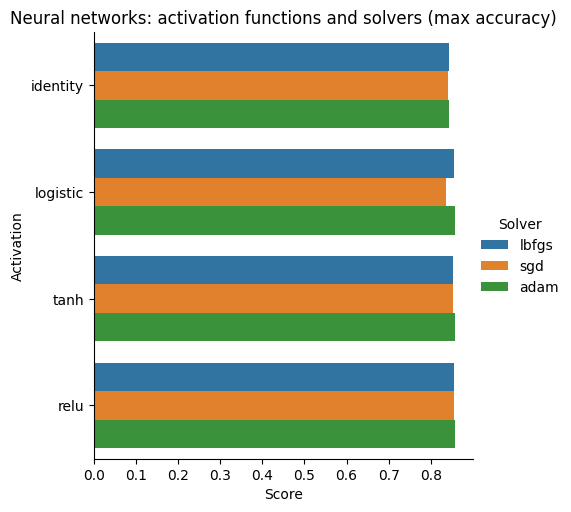

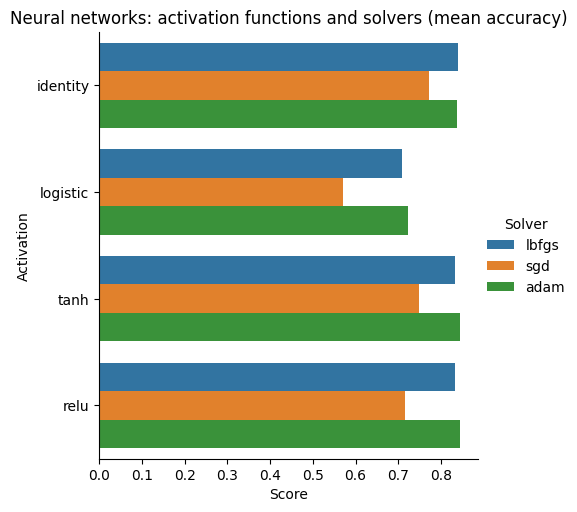

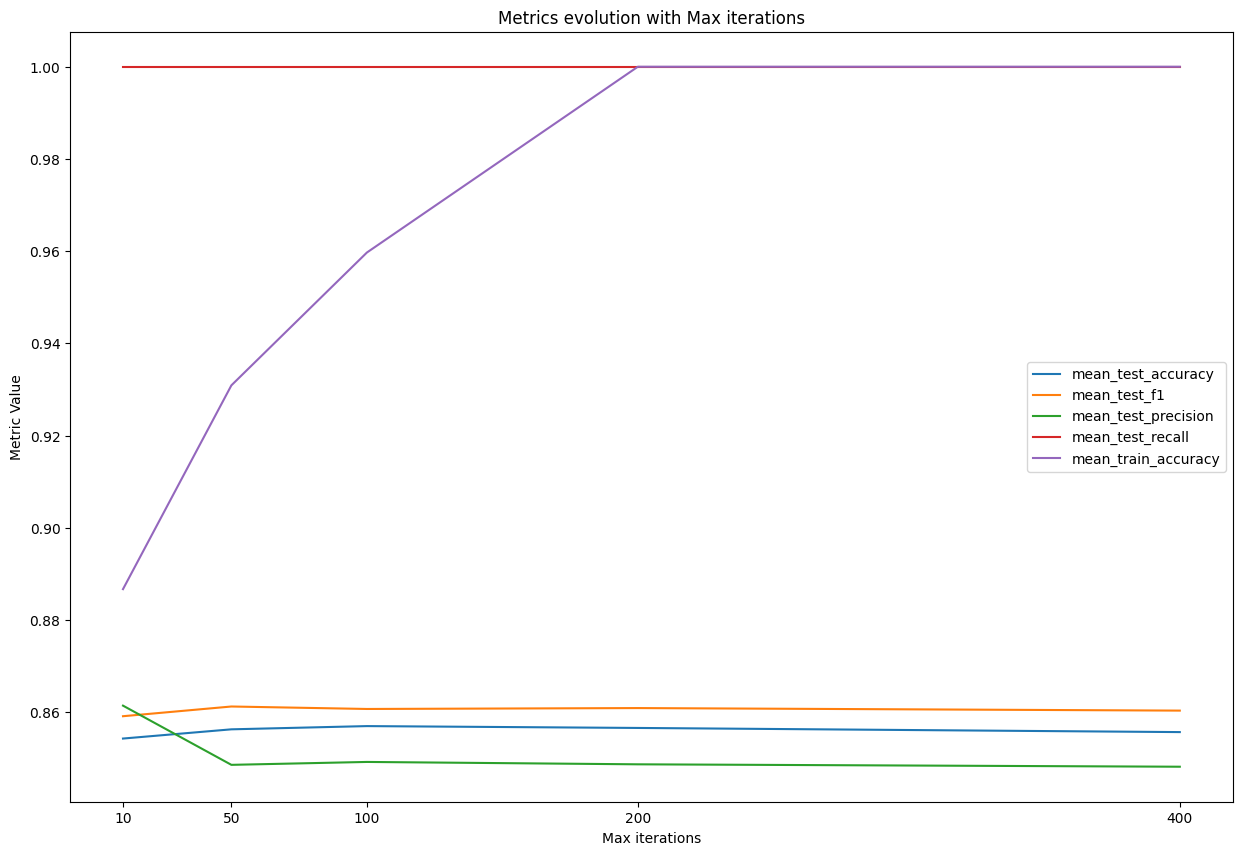

In [132]:
def get_accuracy_nn_plot_helper(activation_func, solver):
    accuracies = grid_search_neural_networks.cv_results_['mean_test_accuracy']
    params = grid_search_neural_networks.cv_results_['params']
    max_value = 0
    sum_values, count_values = 0, 0
    for param, acc in zip(params, accuracies):
        if param['solver'] == solver and param['activation'] == activation_func:
            sum_values += acc
            count_values += 1
            max_value = max(max_value, acc)
    
    return max_value, sum_values / count_values

def plot_neural_networks_dataframe(df, additional_text, filename):
    sb.catplot(x="Score", y="Activation", hue="Solver", data=df, kind="bar", dodge=True, errorbar=None)
    plt.title('Neural networks: activation functions and solvers' + additional_text)
    plt.ylabel('Activation')
    plt.xlabel('Score')
    plt.savefig(get_images_file_path(filename), bbox_inches="tight")

def plot_neural_networks():
    # plot the accuracy for each pair (activation, solver)
    data_max = []
    data_mean = []
    for act in activations:
        for solv in solvers:
            max_acc, mean_acc = get_accuracy_nn_plot_helper(act, solv)
            data_max.append({
                "Activation": act,
                "Solver": solv,
                "Score": max_acc
            })
            data_mean.append({
                "Activation": act,
                "Solver": solv,
                "Score": mean_acc
            })
    data_max = pd.DataFrame(data_max)
    data_mean = pd.DataFrame(data_mean)

    plot_neural_networks_dataframe(data_max, " (max accuracy)", "neural_networks_activations_solvers_max.png")
    plt.show()

    plot_neural_networks_dataframe(data_mean, " (mean accuracy)", "neural_networks_activations_solvers_mean.png")
    plt.show()

plot_neural_networks()
plot_measures(
    "max_iter",
    "Max iterations",
    parameter_grid_neural_networks["max_iter"],
    grid_search_neural_networks.cv_results_,
    [f"mean_test_{metric}" for metric in nn_metrics] + ["mean_train_accuracy"],
    "metrics_vs_max_iter.png",
)

## _Random Forest_

In [133]:
random_forest = RandomForestClassifier()

parameter_grid_random_forest = {
    "n_estimators": [10, 50, 100, 150],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [grid_search_dt.best_params_["max_depth"]],
    "max_features": [grid_search_dt.best_params_["max_features"]],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

print(parameter_grid_random_forest)
rf_metrics = ["accuracy", "f1", "precision", "recall"]

grid_search_random_forest = test_classifier(
    random_forest,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_random_forest,
    return_metrics=rf_metrics,
    optimize_metric="f1",
)

{'n_estimators': [10, 50, 100, 150], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [8], 'max_features': [25], 'class_weight': [None, 'balanced', 'balanced_subsample']}
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best score: 0.845905527554321
Best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_depth': 8, 'max_features': 25, 'n_estimators': 50}


In [134]:
best_params["Random Forest"] = grid_search_random_forest.best_params_

Best score: 0.845905527554321
Best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_depth': 8, 'max_features': 25, 'n_estimators': 50}


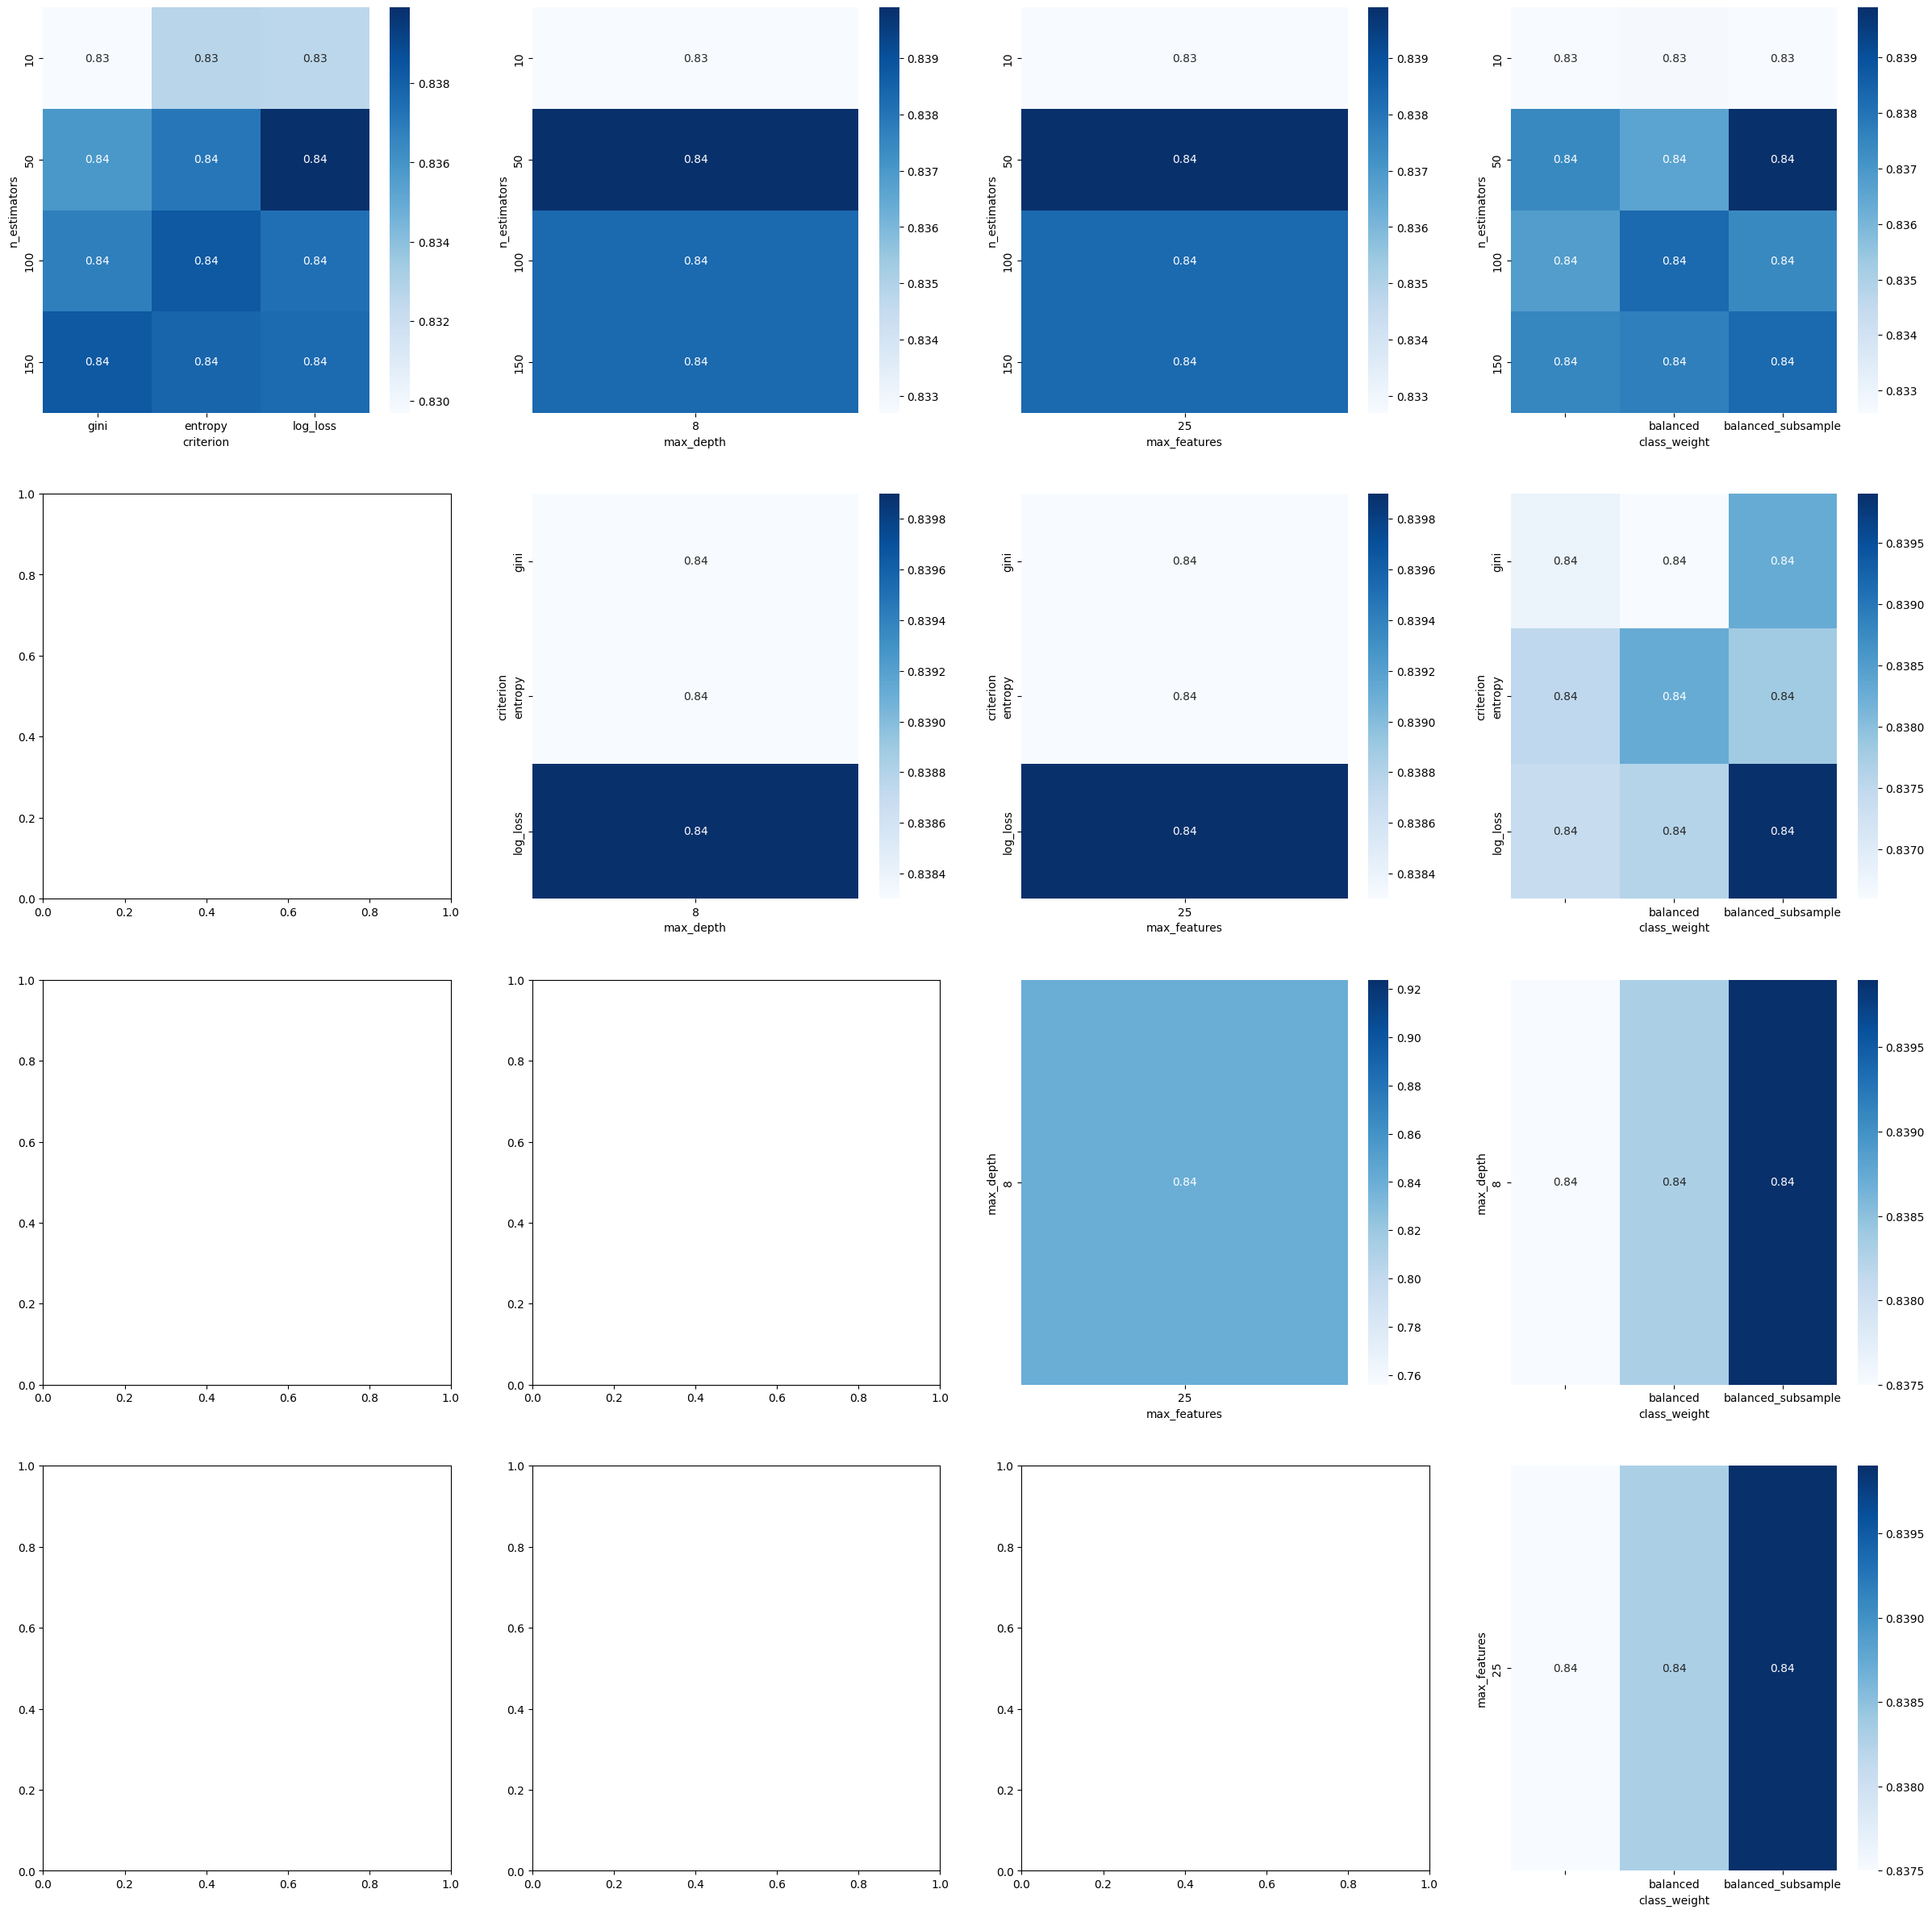

In [135]:
parameter_names_random_forest = list(parameter_grid_random_forest.keys())
plot_grid_search(
    grid_search_random_forest,
    "mean_test_accuracy",
    parameter_grid_random_forest,
    parameter_names_random_forest,
    "heatmaps_random_forest.png"
)

In [136]:
dict_to_json(best_params, "best_params.json")